In [23]:
# Add subject ID information for each path
import re

def get_subject_id(filepath):
    if filepath.endswith("pkl"):
        # Regular expression to match the UUID in the middle of the file path
        match = re.search(r'[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}', filepath)
        if match:
            return match.group(0)
        return None
    elif filepath.endswith("edf"):
        parts = filepath.split('/')
        subject_id = parts[2]  # The subject ID is the third element after splitting by '/'
        return subject_id
    else:
        assert False, f"invaliv file format for file {filepath}"

srs = {}

# File paths
index_paths = [
    "/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json", 
    "/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json"
]

short_index = []

# Load data
index = []
for index_path in index_paths:
    with open(index_path, 'r') as file:
        index_chunk = json.load(file)
        for index_element in index_chunk:
            if get_subject_id(index_element["path"]) == "4c4fd0f0-a2e7-11ee-b865-001e6744589c":
                short_index.append(index_element)

assert len(short_index) == 560, "expected 560 trials for MI_Limb"

assert False, "break before dumping"

idx_path = '/itet-stor/maxihuber/deepeye_storage/index_files/MI_Limb_4c4fd0f0-a2e7-11ee-b865-001e6744589c_index.json'
with open(idx_path, 'w') as file:
    json.dump(short_index, file)
    print("Dumped file!")

assert False, "break before bullshit"

for index_element in index:
    if index_element["sr"] not in srs:
        srs[index_element["sr"]] = 1
    else:
        srs[index_element["sr"]] += 1
    if srs[index_element["sr"]] < 1000:
        short_index.append(index_element)

print(srs)
print(len(short_index))

assert False, "break before dumping"

idx_path = '/itet-stor/maxihuber/deepeye_storage/index_files/short_diverse_sr_index.json'
with open(idx_path, 'w') as file:
    json.dump(short_index, file)
    print("Dumped file!")

import matplotlib.pyplot as plt

# Given data
data = srs

# Sort the data by keys
sorted_keys = sorted(data.keys())
sorted_values = [data[key] for key in sorted_keys]

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(sorted_keys, sorted_values, width=10)
plt.xlabel('Sampling Rate')
plt.ylabel('Count')
plt.title('Sampling Rates')
plt.show()

Dumped file!


AssertionError: break before bullshit

In [14]:
spg_shapes = []
for sr in sorted(srs):
    spg_shapes.append(int(sr / 2 // 16 * 16))
print(spg_shapes)

[48, 64, 80, 96, 112, 128, 192, 240, 256, 272, 272, 272, 352, 496]


# Implement collate_fn

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torchaudio
import lightning as L

L.seed_everything(0, workers=True)

[rank: 0] Seed set to 0


0

## Truncated setup() method

### Load some data into tikgpu10's scratch

In [2]:
# make diverse short_pkl_index

pkl_index_path = "/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json"

# just sample an index_element for each dataset from the lists for short_pkl_index
with open(pkl_index_path, 'r') as file:
    pkl_index = json.load(file)

    datasets_path = "/home/maxihuber/eeg-foundation/development/experiment_management/dataset_to_id.json"
    dataset_to_index_element = {}

    with open(datasets_path, 'r') as file:
        datasets = list(json.load(file).keys())
        print(len(datasets))

    for index_element in pkl_index:
        if not index_element["Dataset"] in dataset_to_index_element:
            dataset_to_index_element[index_element["Dataset"]] = index_element

    short_pkl_index = []
    for dataset, index_element in dataset_to_index_element.items():
        short_pkl_index.append(index_element)

print("pkl index:", len(pkl_index))
print("short pkl index:", len(short_pkl_index))

assert False, "break before dumping"

short_pkl_index_path = "/itet-stor/maxihuber/deepeye_storage/index_files/short_pkl_index.json"
with open(short_pkl_index_path, 'w') as file:
    json.dump(short_pkl_index, file, indent=4)
    print("Dumped file!")

29
pkl index: 347460
short pkl index: 28


AssertionError: break before dumping

In [ ]:
# adjusted the p_loader to chop signals to 1s, 2s, ..., 32s based on the code in the Preloading notebook
# for the moment: just truncate the >32s signals to one signal, don't want a tueg domination for developing collate_fn

# then used the /home/maxihuber/eeg-foundation/job_scripts/train_slurm/combined_script.slurm script to load some signals onto /scratch

### Collect filepaths

In [3]:
# load the paths list we want to work with for this sample problem
paths = {}
sampling_rates = {}
num_datapoints = 0

path_to_data_index = '/scratch/mae/data_index_0.txt'

with open(path_to_data_index, "r") as index_file:
    chunks_index = json.load(index_file)
    for _, chunk_dict in chunks_index.items():
        # paths.append(chunk_dict["path"])
        # sampling_rates.append(chunk_dict["sr"])
        paths[num_datapoints] = chunk_dict["path"]
        sampling_rates[num_datapoints] = chunk_dict["sr"]
        num_datapoints += 1

print(num_datapoints)

937


## Dataset and Dataloader

In [4]:
class custom_fft:
    """
    FFT transform that takes in a window size and shift
    and computes the spectrogram using the torchaudio library.

    The output is converted to decibel scale, and normalized to have zero mean and unit variance.
    """

    def __init__(self, window_seconds, window_shift, sr, cuda=False):
        super().__init__()
        win_length = int(sr * window_seconds)
        hop_length = int(sr * window_shift)
        self.fft = torchaudio.transforms.Spectrogram(
            n_fft=win_length,
            win_length=win_length,
            hop_length=hop_length,
            normalized=True,
        )
        if cuda:
            self.fft = self.fft.to("cuda")

    def __call__(self, data):
        """
        Apply short-time Fourier transform (STFT) to the input data.

        Args:
            data (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The transformed data.
        """
        spg = self.fft(data)
        spg = spg**2
        return spg


def crop_spg(spg):
    # Crop spg to the nearest multiple of 16 in both dimensions
    new_height = (
        spg.shape[0] // 16
    ) * 16  # Integer division and multiplication to find the nearest multiple
    new_width = (spg.shape[1] // 16) * 16
    spg = spg[:new_height, :new_width]  # Crop both dimensions
    return spg


def normalize_spg(spg):
    # Divide spectrogram by frequency bin-wise means
    freq_means = spg[:, :].mean(dim=1, keepdim=True)
    # Divide each frequency bin by its mean
    normalized_spg = spg[:, :] / freq_means
    # Transform to decibel-scale
    db_spg = 10 * torch.log10(normalized_spg)
    return db_spg


def plot_spg(spg, sr, dur):
    plt.pcolormesh(spg, shading="auto", cmap="viridis")
    plt.ylabel("Frequency Bins")
    plt.xlabel("steps")
    plt.title(f"Spectrogram: {sr}, {dur}")
    plt.colorbar(label="")
    plt.show()


class SimpleDataset(Dataset):

    def __init__(self, paths, sampling_rates):
        self.paths = paths
        self.sampling_rates = sampling_rates
        self.ffts = {}  # we have different STFTs for different sampling rates

    def __getitem__(self, idx):
        signal_path = self.paths[idx]
        signal_sr = self.sampling_rates[idx]
        signal_chunk = np.load(signal_path)
        signal_chunk = torch.from_numpy(signal_chunk)

        if signal_sr not in self.ffts:
            self.ffts[signal_sr] = custom_fft(
                window_seconds=1,
                window_shift=1/16,
                sr=signal_sr,
                cuda=False,
            )

        # == apply transforms to raw signal (on CPU) ==
        
        # Applies STFT, returns spectrogram in DB (Decibel) scale
        spg = self.ffts[signal_sr](signal_chunk)  # Compute the spectrogram using FFT.
        # Crop spectrogram to target_size
        spg = crop_spg(spg)
        # Normalize cropped spectrogram (for model input)
        spg = normalize_spg(spg)
        spg.unsqueeze_(0)

        return spg, signal_sr

    def __len__(self):
        return len(self.paths)

# == Initialize Datasets ==
entire_dataset = SimpleDataset(
    paths=paths,
    sampling_rates=sampling_rates,
)

train_val_split = [.95, .05]

train_size = int(train_val_split[0] * len(entire_dataset))
val_size = len(entire_dataset) - train_size

print("DATASETSIZE IS:::::::::::::::::::", len(entire_dataset))
print("TRAINSIZE IS:::::::::::::::::::::", train_size)
print("VALSIZE IS:::::::::::::::::::::::", val_size)

L.seed_everything(0, workers=True)
# Instantiate datasets for training and validation
train_dataset, val_dataset = torch.utils.data.random_split(
    entire_dataset, [train_size, val_size]
)

assert len(train_dataset) + len(val_dataset) == len(entire_dataset), "lost some samples"

[rank: 0] Seed set to 0


DATASETSIZE IS::::::::::::::::::: 937
TRAINSIZE IS::::::::::::::::::::: 890
VALSIZE IS::::::::::::::::::::::: 47


In [8]:
def train_dataloader(train_dataset, batch_sz, custom_collate_fn, num_workers=0, shuffle=True, pin_memory=True, prefetch_factor=None):
    return DataLoader(
        train_dataset,
        batch_size=batch_sz,
        collate_fn=custom_collate_fn,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
    )

## Custom collate_fn Implementation

In [9]:
batch_sz = 4

def z_score_normalize(spg):
    mean = spg.mean()
    std = spg.std()
    spg = (spg - mean) / std

    # Min-Max scaling to [-1, 1]
    spg_min = spg.min()
    spg_max = spg.max()
    spg = 2 * (spg - spg_min) / (spg_max - spg_min) - 1

    return spg

def plot_batch_spgs(batch):
    max_y, max_x = max([spg.shape[1] for spg, sr in batch]), max([spg.shape[2] for spg, sr in batch])  # Define max_grid dimensions
    grid_size = int(np.ceil(np.sqrt(len(batch))))  # Determine the grid size for subplots
    
    #fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig, axes = plt.subplots(1, batch_sz, figsize=(15, 5))

    for idx, (spg, sr) in enumerate(batch):
        #ax = axes[idx // grid_size, idx % grid_size]
        ax = axes[idx]
        
        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')

        spg = z_score_normalize(spg)

        # Set the extent to place the spectrogram in the fixed grid
        cax = ax.imshow(spg.squeeze(0), cmap="viridis", 
                        extent=[0, spg.shape[2], 0, spg.shape[1]],
                        origin='lower', aspect='auto')
        
        # Set the fixed limits for the grid
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
        
        ax.set_ylabel("Frequency Bins")
        ax.set_xlabel("Steps")
        ax.set_title(f"Spectrogram {idx + 1}, {spg.shape}")
        fig.colorbar(cax, ax=ax)

        # Overlay grid lines every 16 pixels
        ax.set_xticks(np.arange(0, max_x+1, 16))
        ax.set_yticks(np.arange(0, max_y+1, 16))
        ax.grid(which='both', color='white', linestyle='-', linewidth=0.5)
        
    # Remove any unused subplots
    for i in range(len(batch), grid_size * grid_size):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def goofy_crop(spg, sr, target_size):
    spg = spg[:, :target_size[0], :target_size[1]] 
    return spg, sr


def rand_collate_fn(batch):
    torch.randn(batch.shape[0], 1, 64, 64)

def custom_collate_fn(batch):
    print("=" * 5 + " entering collate_fn " + "=" * 80, file=sys.stderr)
    
    # max/min height and width of spectrograms within this batch
    max_y, max_x = max([spg.shape[1] for spg, sr in batch]), max([spg.shape[2] for spg, sr in batch])
    min_y, min_x = min([spg.shape[1] for spg, sr in batch]), min([spg.shape[2] for spg, sr in batch])

    print(f"max_y: {max_y}, max_x: {max_x}")
    print(f"min_y: {min_y}, min_x: {min_x}")
    
    #plot_batch_spgs(batch)
    
    processed_samples = []
    for spg, sr in batch:
        print(spg.shape)
        sample = goofy_crop(spg, sr, [min_y, min_x])
        print(sample[0].shape)
        processed_samples.append(sample)

    # plot the batch here
    #print("=" * 100)
    #plot_batch_spgs(processed_samples)

    # we can discard the sr information after having collated the samples
    processed_samples = [spg for spg, sr in processed_samples]
    num_patches = sum([spg.shape[1] // 16 * spg.shape[2] // 16 for spg in processed_samples])
    print("num_patches: ", file=sys.stderr)
        
    print("=" * 5 + " exiting collate_fn " + "=" * 80, file=sys.stderr)

    return torch.stack(processed_samples)

## Running Code

In [122]:
#L.seed_everything(0, workers=True)
device = "cpu"

train_loader = train_dataloader(train_dataset, batch_sz, custom_collate_fn)

# Create an iterator from the DataLoader
train_iterator = iter(train_loader)

# Fetch the next batch
next_batch = next(train_iterator)

next_batch = next_batch.to(device)
print(next_batch.shape) # B, C, H, W
print(next_batch.device)

max_y: 352, max_x: 112
min_y: 240, min_x: 64
torch.Size([1, 256, 80])
torch.Size([1, 240, 64])
torch.Size([1, 240, 112])
torch.Size([1, 240, 64])
torch.Size([1, 256, 112])
torch.Size([1, 240, 64])
torch.Size([1, 352, 64])
torch.Size([1, 240, 64])
torch.Size([4, 1, 240, 64])
cpu


===== entering collate_fn ================================================================================
num_patches: 
===== exiting collate_fn ================================================================================


===== entering forward ================================================================================
at fwd entry: torch.Size([4, 1, 128, 128]) (B, C, H, W)
===== encoder pass ========================================
after patch_embed: torch.Size([4, 64, 384]) (B, L, D)
after random_masking: torch.Size([4, 54, 384]) (B, L, D)
after cat cls_tokens: torch.Size([4, 55, 384]) (B, L, D)
after blocks: torch.Size([4, 55, 384]) (B, L, D)
after norm: torch.Size([4, 55, 384]) (B, L, D)
== after fwd encoder: torch.Size([4, 55, 384]) (B, C, H, W)
===== decoder pass ========================================
after decoder_embed: torch.Size([4, 55, 512]) ?
mask_tokens: torch.Size([4, 10, 512]) ?
after appending mask_tokens: torch.Size([4, 65, 512]) ?
after removing cls_token: torch.Size([4, 64, 512]) ?
before decoder_blocks torch.Size([4, 64, 512]) ?


RuntimeError: shape '[4, 4, 4, 512]' is invalid for input of size 131072

# ==Custom Sampler======================================

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('/home/maxihuber/eeg-foundation')

import torch
from torch.utils.data import DataLoader, Dataset
import torchaudio
import lightning as L

L.seed_everything(0, workers=True)

[rank: 0] Seed set to 0


0

### ==Plotting methods====

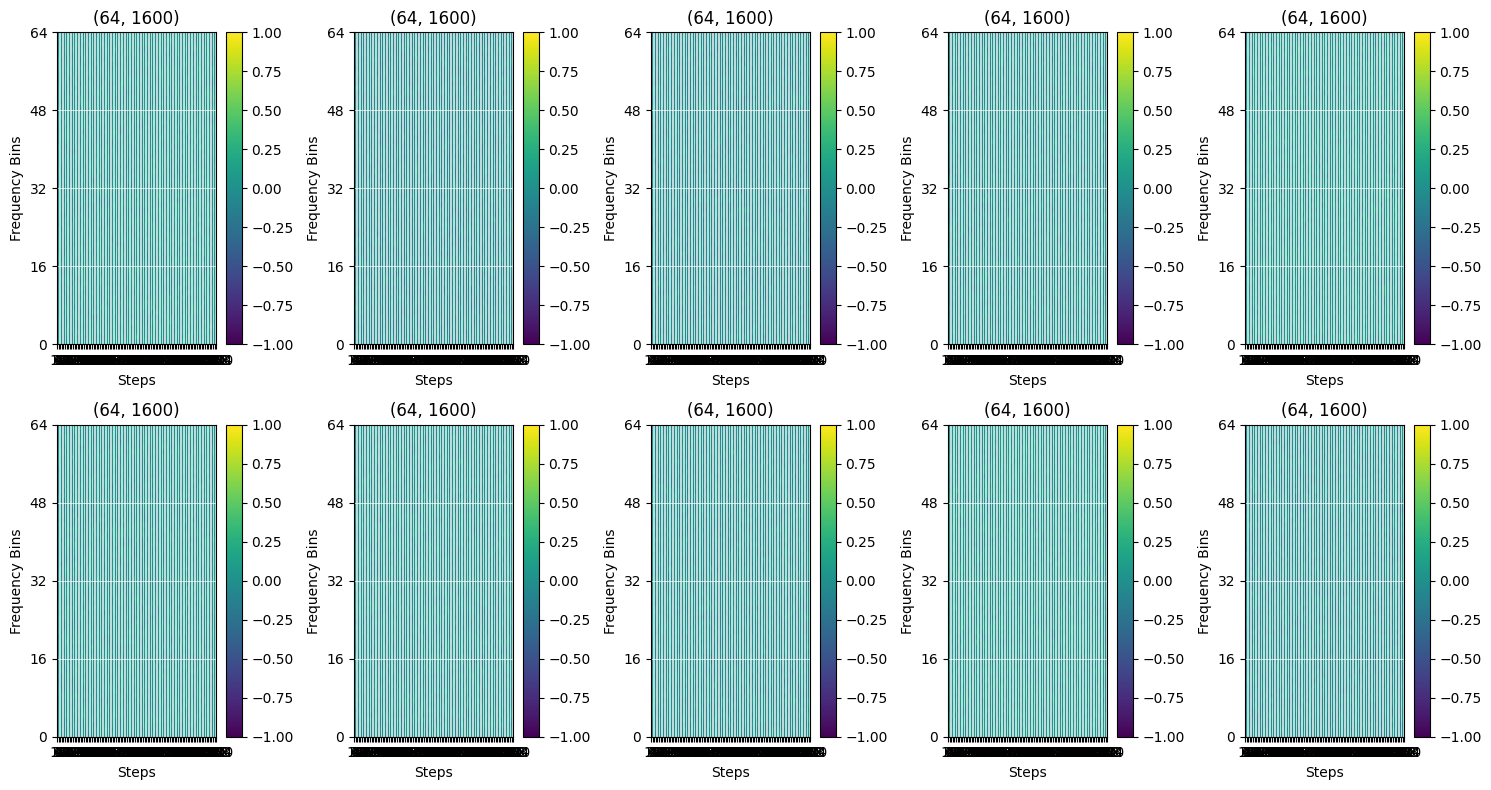

In [30]:
def z_score_normalize(spg):
    mean = spg.mean()
    std = spg.std()
    spg = (spg - mean) / std

    # Min-Max scaling to [-1, 1]
    spg_min = spg.min()
    spg_max = spg.max()
    spg = 2 * (spg - spg_min) / (spg_max - spg_min) - 1

    return spg

from math import ceil

def plot_batch_spgs(batch):
    batch_sz = len(batch)
    max_y, max_x = max([spg.shape[1] for spg in batch]), max([spg.shape[2] for spg in batch])  # Define max_grid dimensions

    nr_spgs_on_line = 5
    grid_y, grid_x = ceil(batch_sz / nr_spgs_on_line), nr_spgs_on_line  # Determine the grid size for subplots
    grid_size = grid_y * grid_x
    
    #fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig, axes = plt.subplots(grid_y, grid_x, figsize=(15, 4 * grid_y))

    for idx, spg in enumerate(batch):
        ax = axes[idx // grid_x, idx % grid_x] if batch_sz > nr_spgs_on_line else axes[idx % grid_x]
        
        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')
        
        spg = z_score_normalize(spg)
        spg.squeeze_(0)
        spg = spg.detach().numpy()
        #print("spg.shape", spg.shape)

        # Set the extent to place the spectrogram in the fixed grid
        cax = ax.imshow(spg, cmap="viridis", 
                        extent=[0, spg.shape[1], 0, spg.shape[0]],
                        origin='lower', aspect='auto')
        
        # Set the fixed limits for the grid
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
        
        ax.set_ylabel("Frequency Bins")
        ax.set_xlabel("Steps")
        ax.set_title(f"{spg.shape}")
        fig.colorbar(cax, ax=ax)

        # Overlay grid lines every 16 pixels
        ax.set_xticks(np.arange(0, max_x+1, 16))
        ax.set_yticks(np.arange(0, max_y+1, 16))
        ax.grid(which='both', color='white', linestyle='-', linewidth=0.5)
        
    # Remove any unused subplots
    for i in range(batch_sz, 1 * batch_sz):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet
import torch

# Assuming your batch is a tensor of shape (B, C, H, W)
def plot_batch_spgs_new(batch):
    batch_sz = batch.shape[0]
    max_y, max_x = batch.shape[2], batch.shape[3]  # Define max_grid dimensions

    nr_spgs_on_line = 5
    grid_y, grid_x = ceil(batch_sz / nr_spgs_on_line), nr_spgs_on_line  # Determine the grid size for subplots
    fig, axes = plt.subplots(grid_y, grid_x, figsize=(15, 4 * grid_y))

    for idx in range(batch_sz):
        spg = batch[idx]
        ax = axes[idx // grid_x, idx % grid_x] if batch_sz > nr_spgs_on_line else axes[idx % grid_x]

        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')

        spg = spg.squeeze(0).detach().numpy()
        spg = z_score_normalize(spg)

        # Create MNE info and epochs object
        sfreq = 200  # Sampling frequency
        ch_names = [f'EEG {i+1:03d}' for i in range(spg.shape[0])]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        epochs_data = spg[np.newaxis, :, :]  # Shape: (1, n_channels, n_times)
        epochs = mne.EpochsArray(epochs_data, info)

        # Define frequency range and time window for analysis
        freqs = np.linspace(1, 35, 35)  # Frequency range from 1 to 35 Hz
        n_cycles = freqs / 2.  # Number of cycles in each window (to balance time and frequency resolution)

        # Compute TFR using Morlet wavelets
        power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False)
        avgpower = power.average()

        # Define the baseline period
        baseline_period = (0, 2)  # Baseline period from 0 to 2 seconds

        # Plot the ERSP with baseline correction applied in the plot function
        avgpower.plot(picks=[14], baseline=baseline_period, mode='logratio', axes=ax, show=False, colorbar=True)

        # Customize the plot
        ax.set_title(f'ERSP for Channel {idx + 1}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')

    # Remove any unused subplots
    for i in range(batch_sz, grid_y * grid_x):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming batch is a torch tensor of shape (B, C, H, W)
batch = torch.randn(10, 1, 64, 1600)  # Example batch
plot_batch_spgs(batch)

In [3]:
from collections import defaultdict 
import time

pointer_file_paths = [
    "/itet-stor/maxihuber/net_scratch/runs/972688/tmp/index_path_tikgpu02_0.txt"
]

print(
    "Collecting data from these files:",
    pointer_file_paths
)

signal_index = {}
num_datapoints = 0

data_seconds_from_source = 0
for pointer_file_path in pointer_file_paths:
    # /itet-stor/maxihuber/net_scratch/runs/.../tmp/index_path_*.txt
    with open(pointer_file_path, "r") as pointer_file:
        # Load filepath to the file containing an index on a subset of the stored data
        path_to_data_index = pointer_file.read()
        with open(path_to_data_index, "r") as index_file:
            # Read information about a subset of the files
            chunks_index = json.load(index_file)
            for _, chunk_dict in chunks_index.items():
                signal_index[num_datapoints] = chunk_dict
                data_seconds_from_source += chunk_dict["duration"]
                num_datapoints += 1

print(f"We have {num_datapoints} many signals.")
print(f"This is {data_seconds_from_source} seconds.")

"""
signal_index is of the following shape:
{
    0: {"path": path/to/signal0.npy, "sr": ..., "duration": ..., "channel": ..., "SubjectID": ...},
    1: {"path": path/to/signal1.npy, "sr": ..., "duration": ..., "channel": ..., "SubjectID": ...},
    ...
    num_datapoints-1: {"path": path/to/signal1.npy, "sr": ..., "duration": ..., "channel": ..., "SubjectID": ...},

"""

# Sampling rates and corresponding max durations
max_durations = {
    100: 1000, 128: 1000, 160: 1000, 200: 1000, 250: 1000, 256: 1000, 400: 1000,
    500: 1000, 512: 1000, 563: 1000, 565: 1000, 567: 1000, 717: 1000, 1000: 1000
}

# subject_id -> channel -> [(path/to/signal, sr, dur, time_used)]
# time_used is how many seconds of this signal we have already used within a batch
id_to_channel_to_signals = {}

for idx, index_element in signal_index.items():
    # TODO: can remove this line after having changed the pre-loading code   
    subject_id = index_element["SubjectID"]
    channel = index_element["channel"]
    if subject_id not in id_to_channel_to_signals:
        id_to_channel_to_signals[subject_id] = {channel: [[idx, index_element]]}
    else:
        if channel not in id_to_channel_to_signals[subject_id]:
            id_to_channel_to_signals[subject_id][channel] = [[idx, index_element]]
        else:
            id_to_channel_to_signals[subject_id][channel].append([idx, index_element])

for subject_id, channel_to_signals in id_to_channel_to_signals.items():
    channel_to_duration = {channel: sum([signal[1]["duration"] for signal in signals]) for channel, signals in channel_to_signals.items()}
    print(f"{subject_id}:", channel_to_duration)

We have 25010 many signals.
This is 175070 seconds.
4c4fd0f0-a2e7-11ee-b865-001e6744589c: {'F1': 3766, 'F7': 3682, 'FC5': 3206, 'FC3': 3899, 'FC1': 3920, 'C1': 3661, 'C3': 3913, 'C5': 3374, 'T7': 2954, 'TP7': 3430, 'P1': 1841, 'P3': 3906, 'P5': 2576, 'P9': 2744, 'O1': 3829, 'Iz': 3675, 'CPZ': 2058, 'FPZ': 497, 'FP2': 1421, 'AF8': 3836, 'AF4': 1316, 'F8': 3913, 'FT8': 3920, 'FC6': 3913, 'FC4': 3899, 'C2': 3822, 'C4': 3710, 'C6': 3920, 'T8': 3920, 'TP8': 3920, 'CP6': 3878, 'CP4': 3920, 'CP2': 3920, 'P2': 3920, 'P4': 3269, 'P6': 3507, 'P8': 3878, 'P10': 3829, 'AVG_REF': 3920, 'F3': 3836, 'F5': 3115, 'FT7': 3822, 'PO7': 1764, 'Oz': 3570, 'POz': 2926, 'Pz': 2093, 'F2': 1309, 'F4': 2744, 'F6': 1316, 'FC2': 3780, 'Cz': 2114, 'PO8': 2765, 'FP1': 2471, 'AF7': 2212, 'AF3': 1414, 'FCz': 133, 'PO3': 140, 'AFZ': 14, 'FZ': 35, 'PO4': 574, 'P7': 238, 'CP5': 189, 'O2': 14}


### Dataset, Sampler, and collate_fn

In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Sampler


# == Initialize Datasets ==
class PathDataset(Dataset):
    def __init__(self, signal_index):
        self.signal_index = signal_index
        self.paths = [index_element["path"] for index_element in signal_index.values()]
        self.len = sum([index_element["duration"] for index_element in signal_index.values()])

    def __getitem__(self, info):
        print(info)
        idx, sr, dur, time_used = info 
        #print(dur)
        signal_path = self.paths[idx]
        signal = np.load(signal_path)
        start_sample = int(sr * time_used)
        end_sample = start_sample + int(sr * dur)
        signal_chunk = signal[start_sample:end_sample]
        return torch.tensor(signal_chunk), sr

    def __len__(self):
        return self.len

# == Initialize Sampler ==
class DurationBasedSampler(Sampler):
    def __init__(self, id_to_channel_to_signals, max_durations, max_duration=35):
        super().__init__()
        self.id_to_channel_to_signals = id_to_channel_to_signals
        self.max_durations = max_durations
        self.max_duration = max_duration
        self.batch_indices = []

    def generate_batches(self):
        self.batch_indices = []

        for subject_id, channel_to_signals in self.id_to_channel_to_signals.items():
            for channel, signals in channel_to_signals.items():
                current_batch = []
                current_duration = 0

                for signal in signals:
                    idx, index_element = signal
                    sr = index_element["sr"]
                    time_used = 0
                    unused_duration = index_element["duration"] - time_used

                    while unused_duration > 0:
                        # Calculate the duration that can be used in the current batch
                        newly_used_duration = min(unused_duration, self.max_duration - current_duration)

                        # Add the signal to the batch
                        current_batch.append((idx, sr, newly_used_duration, time_used))

                        # Update the time_used and current_duration
                        time_used += newly_used_duration
                        current_duration += newly_used_duration

                        # Update the unused_duration
                        unused_duration -= newly_used_duration

                        # If current duration exceeds max duration, finalize the batch and start a new one
                        if current_duration >= self.max_duration:
                            self.batch_indices.append(current_batch)
                            current_batch = []
                            current_duration = 0

                # If there is any remaining batch, add it to the list of batches
                if current_batch:
                    self.batch_indices.append(current_batch)
    
    def __iter__(self):
        self.generate_batches()
        for batch in self.batch_indices:
            yield batch

    def __len__(self):
        return len(self.batch_indices)


from src.data.transforms import custom_fft, crop_and_normalize_spg, normalize_spg
import statistics

# == Collate Function ==
def custom_collate_fn(batch):
    print("signals:", [signal.shape for signal, sr in batch])
   
    # Fourier transform => spectrograms
    fft = custom_fft(
        window_seconds=1,
        window_shift=1 / 16,
        sr=batch[0][1],
        cuda=False,
    )
    spgs = [fft(signal) for signal, sr in batch]

    # Cropping to target dimensions -> this can be done more efficiently
    # Currently, we just crop/pad each spectrogram to median_length (time-axis)
    #  (note: the freq-axis is the same for each spg, as they are from the same subject & dataset)
    #  (question: does adding padding (always at the end)
    spg_lengths = [spg.shape[1] for spg in spgs]
    median_length = int(statistics.median(spg_lengths))
    
    # Crop/pad and normalize spectrograms
    spgs = [crop_and_normalize_spg(spg, median_length) for spg in spgs]

    batch = torch.stack(spgs)
    batch.unsqueeze_(1)

    # Debugging: Plot spectrograms
    #print("[collate_fn] batch size:", batch.shape)
    #plot_batch_spgs(batch)
    
    return batch


temp = """
# == Dataloader ==
entire_dataset = PathDataset(signal_index)
sampler = DurationBasedSampler(id_to_channel_to_signals, max_durations)

# Use the DataLoader with the custom sampler
dataloader = torch.utils.data.DataLoader(entire_dataset, batch_size=1, batch_sampler=sampler, collate_fn=custom_collate_fn, shuffle=False)

## Iterate over the whole batch and see how much seconds of data we have
data_seconds = 0
for i, next_batch in enumerate(dataloader):
    data_seconds += (next_batch.shape[0] * next_batch.shape[3] / 16)
    break
    if i % 100 == 0:
        print(f"{i}: {data_seconds}s")
"""

### ==Network====

In [30]:
from _collections_abc import *
import torch.nn as nn
from timm.models.vision_transformer import Block

TORCH_MAJOR = int(torch.__version__.split('.')[0])
TORCH_MINOR = int(torch.__version__.split('.')[1])

if TORCH_MAJOR == 1 and TORCH_MINOR < 8:
    from torch._six import container_abcs
else:
    import collections.abc as container_abcs

from itertools import repeat

device = "cpu"

# ====Patch Embedding==============================================================================================================

class PatchEmbed_org(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        # From PyTorch internals
        def _ntuple(n):
            def parse(x):
                if isinstance(x, container_abcs.Iterable):
                    return x
                return tuple(repeat(x, n))
            return parse
        
        to_2tuple = _ntuple(2)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_hw = (img_size[1] // patch_size[1], img_size[0] // patch_size[0])

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):

        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = x.float()
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

# ====Random Masking==============================================================================================================

def random_masking_new(batch, mask_ratio):
    # Compute the number of patches
    B, N, D = batch.shape  # B: batch size, N: number of patches, D: embedding dimension
    
    L = N  # Number of patches in one example
    num_masked = int(L * mask_ratio)  # Number of patches to mask
    
    # Generate random indices to mask
    rand_indices = torch.rand(B, L).argsort(dim=1)
    mask_indices = rand_indices[:, :num_masked]
    
    # Gather the values of the patches to be masked before masking them
    masked_patches = torch.gather(batch, 1, mask_indices.unsqueeze(-1).expand(-1, -1, D))
    
    # Zero out the patches at the chosen indices
    batch.scatter_(1, mask_indices.unsqueeze(-1).expand(-1, -1, D), 0)
    
    return batch, masked_patches, mask_indices

# ====Encoder==============================================================================================================
from functools import partial

in_chans=1                                                           
img_size=[64, 64]
patch_size=16
embed_dim=384                                                        
depth=12                                                             
num_heads=6   
mlp_ratio=4 
qkv_bias=True
norm_pix_loss=False
attn_drop_rate=0.0
drop_path_rate=0.0
norm_layer=partial(nn.LayerNorm, eps=1e-6)
act_layer=nn.GELU
dpr=[drop_path_rate for i in range(depth)]
init_scale=1e-4

from src.models.components.vit_rope import RoPEAttention, RoPE_Layer_scale_init_Block
Attention_block=RoPEAttention
block_layers=RoPE_Layer_scale_init_Block

from timm.models.vision_transformer import Mlp as Mlp
Mlp_block=Mlp

# Encoder: patch embedding
patch_embed = PatchEmbed_org(img_size, patch_size, in_chans, embed_dim)

# Encoder: transformer blocks
encoder_blocks = nn.ModuleList(
    [
        block_layers(
            dim=embed_dim,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=None,
            drop=0.0,
            attn_drop=attn_drop_rate,
            drop_path=dpr[i],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            act_layer=act_layer,
            Attention_block=Attention_block,
            Mlp_block=Mlp_block,
            init_values=init_scale,
        )
        for i in range(depth)
    ]
)

# Encoder: stuff
norm = norm_layer(embed_dim)
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

# Encoder: RoPE specifics
rope=True
from src.models.components.vit_rope import compute_axial_cis
rope_theta=100.0
compute_cis = partial(compute_axial_cis, dim=embed_dim // num_heads, theta=rope_theta)
img_size=224
patch_size=16

def forward_encoder(batch, mask_ratio):
    """ """
    B, C, H, W = batch.shape
        
    # make batch a sequence of flattened patches
    batch = patch_embed(batch)
    print("after patch_embed:", batch.shape, "(B, N, D)")
        
    # masking: splits batch into batch, mask
    batch, mask, ids_restore = random_masking_new(batch, mask_ratio)
    print("after random_masking_new:", batch.shape, "(B, N, D)")

    # cls token
    cls_tokens = cls_token.expand(batch.shape[0], -1, -1)
    print("CLS_TOKENS.SHAPE:", cls_tokens.shape)
    batch = torch.cat((cls_tokens, batch), dim=1)
    print("after cat cls_tokens:", batch.shape, "(B, N, D)")
    
    # TODO: (?) channel token
    
    # Transformer blocks
    B, N, D = batch.shape
    
    # recompute freqs_cis each batch (for simplicity)
    freqs_cis = compute_axial_cis(dim=embed_dim // num_heads, end_x = W // patch_size, end_y = H // patch_size, theta=rope_theta)
    freqs_cis = freqs_cis.to(batch.device)
    print("freqs_cis.shape", freqs_cis.shape)
    
    for i, blk in enumerate(encoder_blocks):
        batch = blk(batch, freqs_cis=freqs_cis)
    print("after rope blocks:", batch.shape, "(B, L, D)")

    batch = norm(batch)
    print("after rope norm:", batch.shape, "(B, L, D)")

    return batch, mask, ids_restore


# ====Decoder==============================================================================================================
from timm.models.swin_transformer import SwinTransformerBlock # Note: causes the torch.meshgrid warning

mlp_ratio=4                                                          
decoder_embed_dim=512                                                
decoder_num_heads=16                                                 
decoder_mode=0
use_custom_patch=False
no_shift=False
decoder_depth=8

decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
decoder_norm = norm_layer(decoder_embed_dim)
# Maps the decoder's output back to the original data space, i.e. reconstructs the original patches
decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2*in_chans, bias=True) 

# Initialize a series of Transformer blocks
decoder_blocks = nn.ModuleList(
    [
        block_layers(
            dim=decoder_embed_dim,
            num_heads=decoder_num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=True,
            qk_scale=None,
            drop=0.0,
            attn_drop=attn_drop_rate,
            drop_path=dpr[i],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
            act_layer=act_layer,
            Attention_block=Attention_block,
            Mlp_block=Mlp_block,
            init_values=init_scale,
        )
        for i in range(depth)
    ]
)

def forward_decoder(x, ids_restore, H, W):
   
    # embed tokens
    print("at forward_decoder entry", x.shape)
    x = decoder_embed(x)
    print("after decoder_embed:", x.shape, "?")

    # Decoder: apply decoder architecture (either SwinTransformerBlocks or TransformerBlocks)
    B, N, D = x.shape

    # recompute freqs_cis each batch (for simplicity)
    freqs_cis = compute_axial_cis(dim=decoder_embed_dim // decoder_num_heads, end_x = W // patch_size, end_y = H // patch_size, theta=rope_theta)
    freqs_cis = freqs_cis.to(x.device)
    
    for i, blk in enumerate(decoder_blocks):
        x = blk(x, freqs_cis=freqs_cis)
    print("after rope decoder blocks:", x.shape, "(B, L, D)")

    x = decoder_norm(x)
    print("after decoder_norm:", x.shape, "?")

    # predictor projection
    pred = decoder_pred(x)
    print("after decoder_pred:", pred.shape, "?")
    
    pred = pred[:, 1:, :]
    print("after cls_token removal:", pred.shape, "?")
    
    return pred

def forward_loss(batch, pred):
    B, C, H, W = batch.shape
    target = patchify(batch, B, H, W)
    print("[forward_loss] target.shape:", target.shape)
    print("[forward_loss] pred.shape:", pred.shape)
    
    # Calculate the squared error
    loss = (pred - target) ** 2
    print("[forward_loss] loss.shape:", loss.shape)
    
    # Compute the mean loss over the last dimension
    loss = loss.mean(dim=-1)
    print("[forward_loss] loss.shape after mean(dim=-1):", loss.shape)
    
    # Compute the mean loss over all patches (second dimension)
    mean_loss = loss.mean()
    print("[forward_loss] mean_loss:", mean_loss.item())
    
    return mean_loss

def patchify(x, B, H, W):
    x = x.reshape(shape=(B, 1, H // patch_size, patch_size, W // patch_size, patch_size))
    x = torch.einsum("nchpwq->nhwpqc", x)
    x = x.reshape(shape=(B, H * W // (patch_size ** 2), patch_size ** 2))
    return x

def unpatchify(x, B, H, W):
    x = x.reshape(shape=(B, H // patch_size, W // patch_size, patch_size, patch_size, 1))
    x = torch.einsum("nhwpqc->nchpwq", x)
    x = x.reshape(shape=(B, 1, H, W))
    return x

def forward(batch, mask_ratio=0.15):

    plot_batch_spgs(batch)
    print("=" * 5, "entering forward", "=" * 80)
    print("at fwd entry:", batch.shape, "(B, C, H, W)")
    B, C, H, W = batch.shape

    print("=" * 5, "encoder pass", "=" * 40)
    
    # == Encoder pass of model ==
    masked_batch_embeddings, masked_patches_embeddings, ids_restore = forward_encoder(batch, mask_ratio)
    plot_batch_spgs(batch)
    print("== after fwd encoder:", masked_batch_embeddings.shape, "(N, L, D)")

    print("=" * 5, "decoder pass", "=" * 40)
    # == Decoder pass of model ==
    # pred: predicted reconstruction (tensor of same shape as emb_enc)
    pred = forward_decoder(masked_batch_embeddings, ids_restore, H, W)  # [N, L, p*p*3]
    print("== after fwd decoder:", pred.shape, "(N, L, D)")

    print("=" * 5, "loss computation", "=" * 40)    
    loss_recon = forward_loss(batch, pred)

In [36]:
def z_score_normalize(spg):
    mean = spg.mean()
    std = spg.std()
    spg = (spg - mean) / std

    # Min-Max scaling to [-1, 1]
    spg_min = spg.min()
    spg_max = spg.max()
    spg = 2 * (spg - spg_min) / (spg_max - spg_min) - 1

    return spg

from math import ceil

def plot_batch_spgs(batch):
    batch_sz = len(batch)
    max_y, max_x = max([spg.shape[1] for spg in batch]), max([spg.shape[2] for spg in batch])  # Define max_grid dimensions

    nr_spgs_on_line = 5
    grid_y, grid_x = ceil(batch_sz / nr_spgs_on_line), nr_spgs_on_line  # Determine the grid size for subplots
    grid_size = grid_y * grid_x
    
    #fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig, axes = plt.subplots(grid_y, grid_x, figsize=(15, 4 * grid_y))

    for idx, spg in enumerate(batch):
        ax = axes[idx // grid_x, idx % grid_x] if batch_sz > nr_spgs_on_line else axes[idx % grid_x]
        
        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')
        
        spg = z_score_normalize(spg)
        spg.squeeze_(0)
        spg = spg.detach().numpy()
        #print("spg.shape", spg.shape)

        # Set the extent to place the spectrogram in the fixed grid
        cax = ax.imshow(spg, cmap="viridis", 
                        extent=[0, spg.shape[1], 0, spg.shape[0]],
                        origin='lower', aspect='auto')
        
        # Set the fixed limits for the grid
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
        
        ax.set_ylabel("Frequency Bins")
        ax.set_xlabel("Steps")
        ax.set_title(f"{spg.shape}")
        fig.colorbar(cax, ax=ax)

        # Overlay grid lines every 16 pixels
        ax.set_xticks(np.arange(0, max_x+1, 16))
        ax.set_yticks(np.arange(0, max_y+1, 16))
        ax.grid(which='both', color='white', linestyle='-', linewidth=0.5)
        
    # Remove any unused subplots
    for i in range(batch_sz, 1 * batch_sz):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet
import torch

# Assuming your batch is a tensor of shape (B, C, H, W)
def plot_batch_spgs_new(batch):
    batch_sz = batch.shape[0]
    max_y, max_x = batch.shape[2], batch.shape[3]  # Define max_grid dimensions

    nr_spgs_on_line = 5
    grid_y, grid_x = ceil(batch_sz / nr_spgs_on_line), nr_spgs_on_line  # Determine the grid size for subplots
    fig, axes = plt.subplots(grid_y, grid_x, figsize=(15, 4 * grid_y))

    for idx in range(batch_sz):
        spg = batch[idx]
        ax = axes[idx // grid_x, idx % grid_x] if batch_sz > nr_spgs_on_line else axes[idx % grid_x]

        # Set the aspect of the plot to be equal
        ax.set_aspect('equal')

        spg = spg.squeeze(0).detach().numpy()
        spg = z_score_normalize(spg)
        print(spg.shape)

        # Create MNE info and epochs object
        sfreq = 200  # Sampling frequency
        ch_names = [f'EEG {i+1:03d}' for i in range(spg.shape[0])]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        epochs_data = spg[np.newaxis, :, :]  # Shape: (1, n_channels, n_times)
        epochs = mne.EpochsArray(epochs_data, info)

        # Define frequency range and time window for analysis
        freqs = np.linspace(1, 35, 35)  # Frequency range from 1 to 35 Hz
        n_cycles = freqs / 7.  # Number of cycles in each window (to balance time and frequency resolution)

        # Compute TFR using Morlet wavelets
        power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False)
        avgpower = power.average()

        # Define the baseline period
        baseline_period = (0, 2)  # Baseline period from 0 to 2 seconds

        # Plot the ERSP with baseline correction applied in the plot function
        avgpower.plot(picks=[14], baseline=baseline_period, mode='logratio', axes=ax, show=False, colorbar=True)

        # Customize the plot
        ax.set_title(f'ERSP for Channel {idx + 1}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')

    # Remove any unused subplots
    for i in range(batch_sz, grid_y * grid_x):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [38]:
import json
chn_names_path = '/itet-stor/maxihuber/net_scratch/runs/972903/tmp/channel_set_tikgpu03_0.txt'
with open(chn_names_path, 'r') as file:
    chn_names = json.load(file)
print(type(chn_names))

<class 'list'>


(0, 200, 7, 0)
(39, 200, 7, 0)
(133, 200, 7, 0)
(176, 200, 7, 0)
(223, 200, 7, 0)
signals: [torch.Size([1400]), torch.Size([1400]), torch.Size([1400]), torch.Size([1400]), torch.Size([1400])]


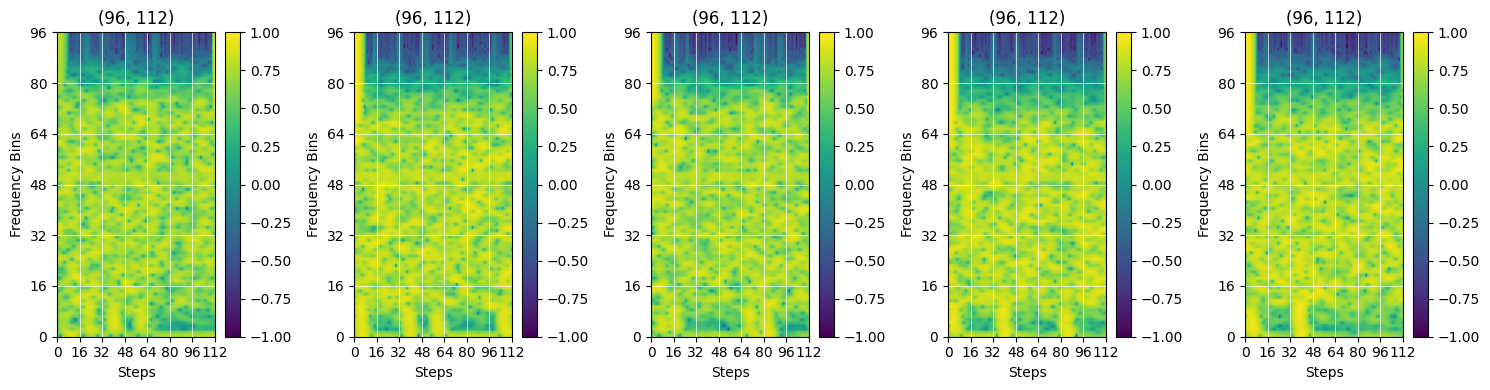

===== entering forward ================================================================================
at fwd entry: torch.Size([5, 1, 96, 112]) (B, C, H, W)
===== encoder pass ========================================
after patch_embed: torch.Size([5, 42, 384]) (B, N, D)
after random_masking_new: torch.Size([5, 42, 384]) (B, N, D)
CLS_TOKENS.SHAPE: torch.Size([5, 1, 384])
after cat cls_tokens: torch.Size([5, 43, 384]) (B, N, D)
freqs_cis.shape torch.Size([42, 32])
after rope blocks: torch.Size([5, 43, 384]) (B, L, D)
after rope norm: torch.Size([5, 43, 384]) (B, L, D)


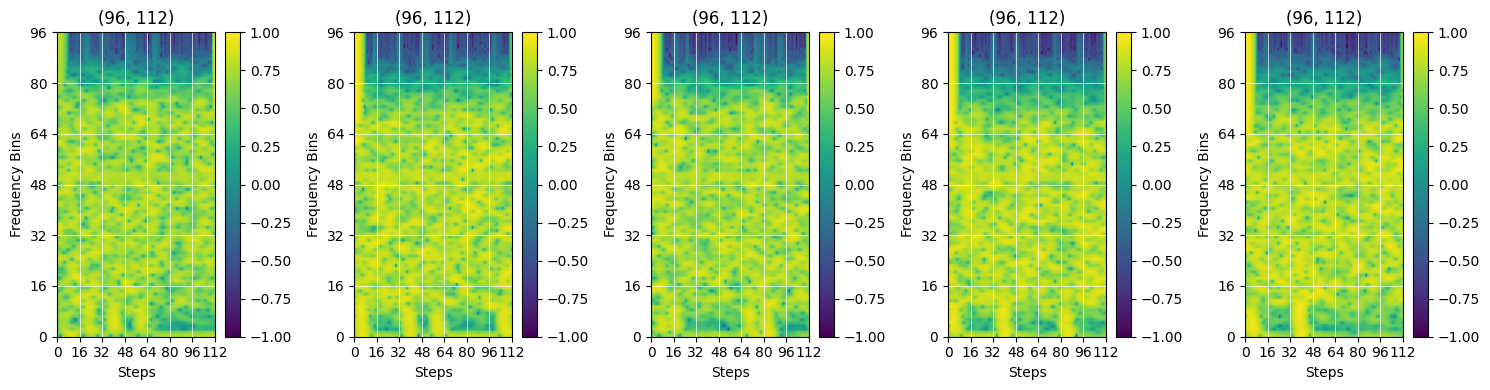

== after fwd encoder: torch.Size([5, 43, 384]) (N, L, D)
===== decoder pass ========================================
at forward_decoder entry torch.Size([5, 43, 384])
after decoder_embed: torch.Size([5, 43, 512]) ?
after rope decoder blocks: torch.Size([5, 43, 512]) (B, L, D)
after decoder_norm: torch.Size([5, 43, 512]) ?
after decoder_pred: torch.Size([5, 43, 256]) ?
after cls_token removal: torch.Size([5, 42, 256]) ?
== after fwd decoder: torch.Size([5, 42, 256]) (N, L, D)
===== loss computation ========================================
[forward_loss] target.shape: torch.Size([5, 42, 256])
[forward_loss] pred.shape: torch.Size([5, 42, 256])
[forward_loss] loss.shape: torch.Size([5, 42, 256])
[forward_loss] loss.shape after mean(dim=-1): torch.Size([5, 42])
[forward_loss] mean_loss: 1947.6907246434337


In [32]:
# == Dataloader ==
entire_dataset = PathDataset(signal_index)
sampler = DurationBasedSampler(id_to_channel_to_signals, max_durations)

# Use the DataLoader with the custom sampler
dataloader = torch.utils.data.DataLoader(entire_dataset, batch_size=1, batch_sampler=sampler, collate_fn=custom_collate_fn, shuffle=False)

## Iterate over the whole batch and see how much seconds of data we have
data_seconds = 0
for i, batch in enumerate(dataloader):
    forward(batch)
    break

### freqs_cis debugging

In [11]:
def compute_axial_cis(dim: int, end_x: int, end_y: int, theta: float = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    
    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)


def init_t_xy(end_x: int, end_y: int):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode="floor").float()
    return t_x, t_y

# Data
batch = torch.randn(4,1,128,128)

# Parameters
patch_size=16
embed_dim=384
rope_theta=100.0

# Computation
B, C, H, W = batch.shape
freqs_cis = compute_axial_cis(dim=embed_dim // num_heads, end_x = W // patch_size, end_y = H // patch_size, theta=rope_theta)

# Output
print(freqs_cis.shape)

torch.Size([64, 32])


In [40]:
# Apply transformations to batch
batch = torch.randn(4,1,64,96) #dummy

# Parameters
dim=embed_dim
qkv_bias=True
self_qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
num_heads=6

"""
Problem description:

At the beginning of forward(self, batch), we have a batch of shape (B, C, H, W)

Based on this shape, we compute the freqs_cis matrix, which is of shape (N, dim // 4 * 2)

We then flatten the batch with patch_embed -> (B, N, D)

Then, we mask some patches -> (B, N', D) [batch] and (B, N-N', D) [mask]

We append a cls_token to the batch -> (B, N'+1, D)

Then, we pass this through the transformer layers. In each attention layer, we compute (self.qkv(batch)),
 which gives us q, k, v -> (B, num_heads, N'+1, dim) [q,k,v each]

We then ignore the cls token q & k value -> (B, num_heads, N', C // num_heads) [q,k both]

q,k and freqs_cis are passed to apply_rotary_emb. Now, the problem starts!

 - freq_cis = (N, 32) and q,k (N', 32) don't match -> AssertionError in reshape_for_broadcast 
"""

# Computation
B, C, H, W = batch.shape
print("batch shape at start:", batch.shape)

freqs_cis = compute_axial_cis(dim=embed_dim // num_heads, end_x = W // patch_size, end_y = H // patch_size, theta=rope_theta)
print("freqs_cis.shape:", freqs_cis.shape)

batch = patch_embed(batch)
print("batch shape patch embed:", batch.shape)

batch, mask, ids_restore = random_masking_new(batch, 0.15)
print("batch shape after mask:", batch.shape)

cls_tokens = cls_token.expand(batch.shape[0], -1, -1)
batch = torch.cat((cls_tokens, batch), dim=1)

B, N, C = batch.shape
print("batch shape after cls:", batch.shape)

qkv = self_qkv(batch)
qkv = qkv.reshape(B, N, 3, num_heads, C // num_heads)
qkv = qkv.permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]
print("{q,k,v}.shape:", q.shape, "(each)")

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    print("reshape_for_broadcast:", freqs_cis.shape, x.shape)
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim - 2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim - 3 else 1 for i, d in enumerate(x.shape)]
    else:
        assert False, "shapes don't match"

    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    print("xq.shape", xq.shape)
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    print("xq_.shape", xq_.shape)
    print("xk.shape", xk.shape)
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    print("xk_.shape", xk_.shape)
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)

# note: we ignore the cls token q & k value (i think)
q[:, :, 1:], k[:, :, 1:] = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)

batch shape at start: torch.Size([4, 1, 64, 96])
freqs_cis.shape: torch.Size([24, 32])
batch shape patch embed: torch.Size([4, 24, 384])
tensor(-0.3412, grad_fn=<SelectBackward0>)
tensor(-0.7702, grad_fn=<SelectBackward0>)
tensor(0.2142, grad_fn=<SelectBackward0>)
tensor(-0.1469, grad_fn=<SelectBackward0>)
tensor(-0.1105, grad_fn=<SelectBackward0>)
tensor(0.4260, grad_fn=<SelectBackward0>)
tensor(-1.2669, grad_fn=<SelectBackward0>)
tensor(-0.6062, grad_fn=<SelectBackward0>)
tensor(-0.5399, grad_fn=<SelectBackward0>)
tensor(-0.4738, grad_fn=<SelectBackward0>)
tensor(-0.1702, grad_fn=<SelectBackward0>)
tensor(0.6686, grad_fn=<SelectBackward0>)
tensor(-0.3854, grad_fn=<SelectBackward0>)
tensor(-0.2129, grad_fn=<SelectBackward0>)
tensor(0.3002, grad_fn=<SelectBackward0>)
tensor(0.3284, grad_fn=<SelectBackward0>)
tensor(-0.8106, grad_fn=<SelectBackward0>)
tensor(0.2101, grad_fn=<SelectBackward0>)
tensor(-0.6645, grad_fn=<SelectBackward0>)
tensor(-0.8275, grad_fn=<SelectBackward0>)
tensor(0.

## Smarter Batch Creation

### 1. Find maximum batch sizes without crashing cuda

### 2. Vary batch creation based on dataset

- have a scheme like dataset -> (batch_size=nr. of signals, signal_duration per element in batch)
- for this, we need to understand how variable datasets are (are all MI_Limb data the same length? especially how about tueg?)
- do we still keep the cropping/padding based on median?

In [1]:
import json

# load all dataset names
dataset_json_path = '/home/maxihuber/eeg-foundation/development/experiment_management/dataset_to_id.json'
with open(dataset_json_path, 'r') as file:
    datasets = list(json.load(file).keys())
print(datasets)

['ERP_ERP_ANA', 'RS_RS_ALPHA', 'ERP_ERP_BISC', 'ERP_ERP_BBI', 'ERP_ERP_BICF', 'ERP_ERP_BICD', 'RS_RS_SPIS', 'MI_MI_HGD', 'MI_MI_SCP', 'ErrP_ErrP_MERP', 'MI_MI_ULM', 'MI_MI_VEP', 'MI_MI_LR', 'MI_BBCI_IV_Graz_b', 'MI_MI_EB', 'MI_BBCI_IV_Graz_a', 'MI_MI_GVH_V', 'MI_MI_GAL', 'MI_MI_Two', 'MI_MI_GVH_H', 'MI_MI_II', 'ErrP_ErrP_BCI', 'MI_MI_GVH_G', 'MI_MI_Limb', 'MI_MI_SCI', 'MI_BBCI_IV_Berlin', 'MI_eegmmidb', 'ERP_ERP_FHD', 'RS_RS_EID']


In [2]:
# Create a new json file, which is a map from
# dataset -> { "Single channel data": ...,
#              "Multiple channel data": ...,
#              "Average trial length": ...,
#              "Average session length": ...,
#              "Number of sessions": ...,
#              "Number of runs": ...,
#              "Number of trials": ...
#            }

import csv
import json

# Define the path to the CSV file and the JSON output file
csv_path = '/home/maxihuber/eeg-foundation/development/experiment_management/DatasetStatistics.csv'
json_output_path = '/home/maxihuber/eeg-foundation/development/experiment_management/dataset_statistics.json'

# Initialize an empty dictionary to hold the data
data = {}

# Read the CSV file
with open(csv_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)  # The first row is the header

    for row in reader:
        metric = row[0].strip()  # The first column is the metric name
        for idx, dataset in enumerate(headers[1:], start=1):
            if dataset not in data:
                data[dataset] = {}
            data[dataset][metric] = float(row[idx]) if row[idx] else None


# Write the data to a JSON file
with open(json_output_path, 'w') as jsonfile:
    json.dump(data, jsonfile, indent=4)
    print(f"Dataset statistics have been written to {json_output_path}")


Dataset statistics have been written to /home/maxihuber/eeg-foundation/development/experiment_management/dataset_statistics.json


In [1]:
import json
import numpy as np

# Iterate over the pkl index, and add the duration to the right dataset_to_durs
index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json'
with open(index_path, 'r') as file:
    index = json.load(file)

# dataset -> list of trial durations
dataset_to_durs = {}

for index_element in index:
    if index_element["Dataset"] not in dataset_to_durs:
        dataset_to_durs[index_element["Dataset"]] = [index_element["duration"]]
    else:
        dataset_to_durs[index_element["Dataset"]].append(index_element["duration"])

# dataset -> (mean duration, std)
dataset_to_statistics = {}

for dataset in sorted(dataset_to_durs):
    dataset_to_statistics[dataset] = [np.mean(dataset_to_durs[dataset]), np.std(dataset_to_durs[dataset])]

print("Dataset:\t[Mean, Std]")
for dataset, statistic in dataset_to_statistics.items():
    print(f"{dataset}:\t", statistic)

Dataset:	[Mean, Std]
ERP_ERP_ANA:	 [8.31139924754069, 7.534297788276978]
ERP_ERP_BBI:	 [5.584207507977026, 3.1051038455465485]
ERP_ERP_BICD:	 [8.536134367740651, 5.809145597708095]
ERP_ERP_BICF:	 [9.133558474254292, 16.53479567449217]
ERP_ERP_BISC_1:	 [11.811668361872146, 8.750622315703655]
ERP_ERP_BISC_2:	 [11.811668361872146, 8.750622315703655]
ErrP_ErrP_BCI:	 [11.79146631590987, 2.559978001320675]
ErrP_ErrP_MERP:	 [2.508576348031496, 0.2883122782562627]
MI_BBCI_IV_Berlin:	 [21.422928216062537, 169.02814410253131]
MI_BBCI_IV_Graz_a:	 [6.981924528301887, 11.842945761184241]
MI_BBCI_IV_Graz_b:	 [10.342755606017597, 9.900010989029543]
MI_MI_EB:	 [8.0069112033195, 14.001170184354507]
MI_MI_GAL:	 [10.733709349593495, 3.7286199604989623]
MI_MI_GVH_G:	 [4.952996363173957, 14.071042686659698]
MI_MI_GVH_H:	 [5.6245890619501475, 13.671704453847303]
MI_MI_GVH_V:	 [5.743357157946091, 13.753210038048088]
MI_MI_HGD:	 [7.632139424503115, 1.344220417396632]
MI_MI_II:	 [13.838853435492956, 4.31774355

In [4]:
print(len(sorted(dataset_to_durs)))

28


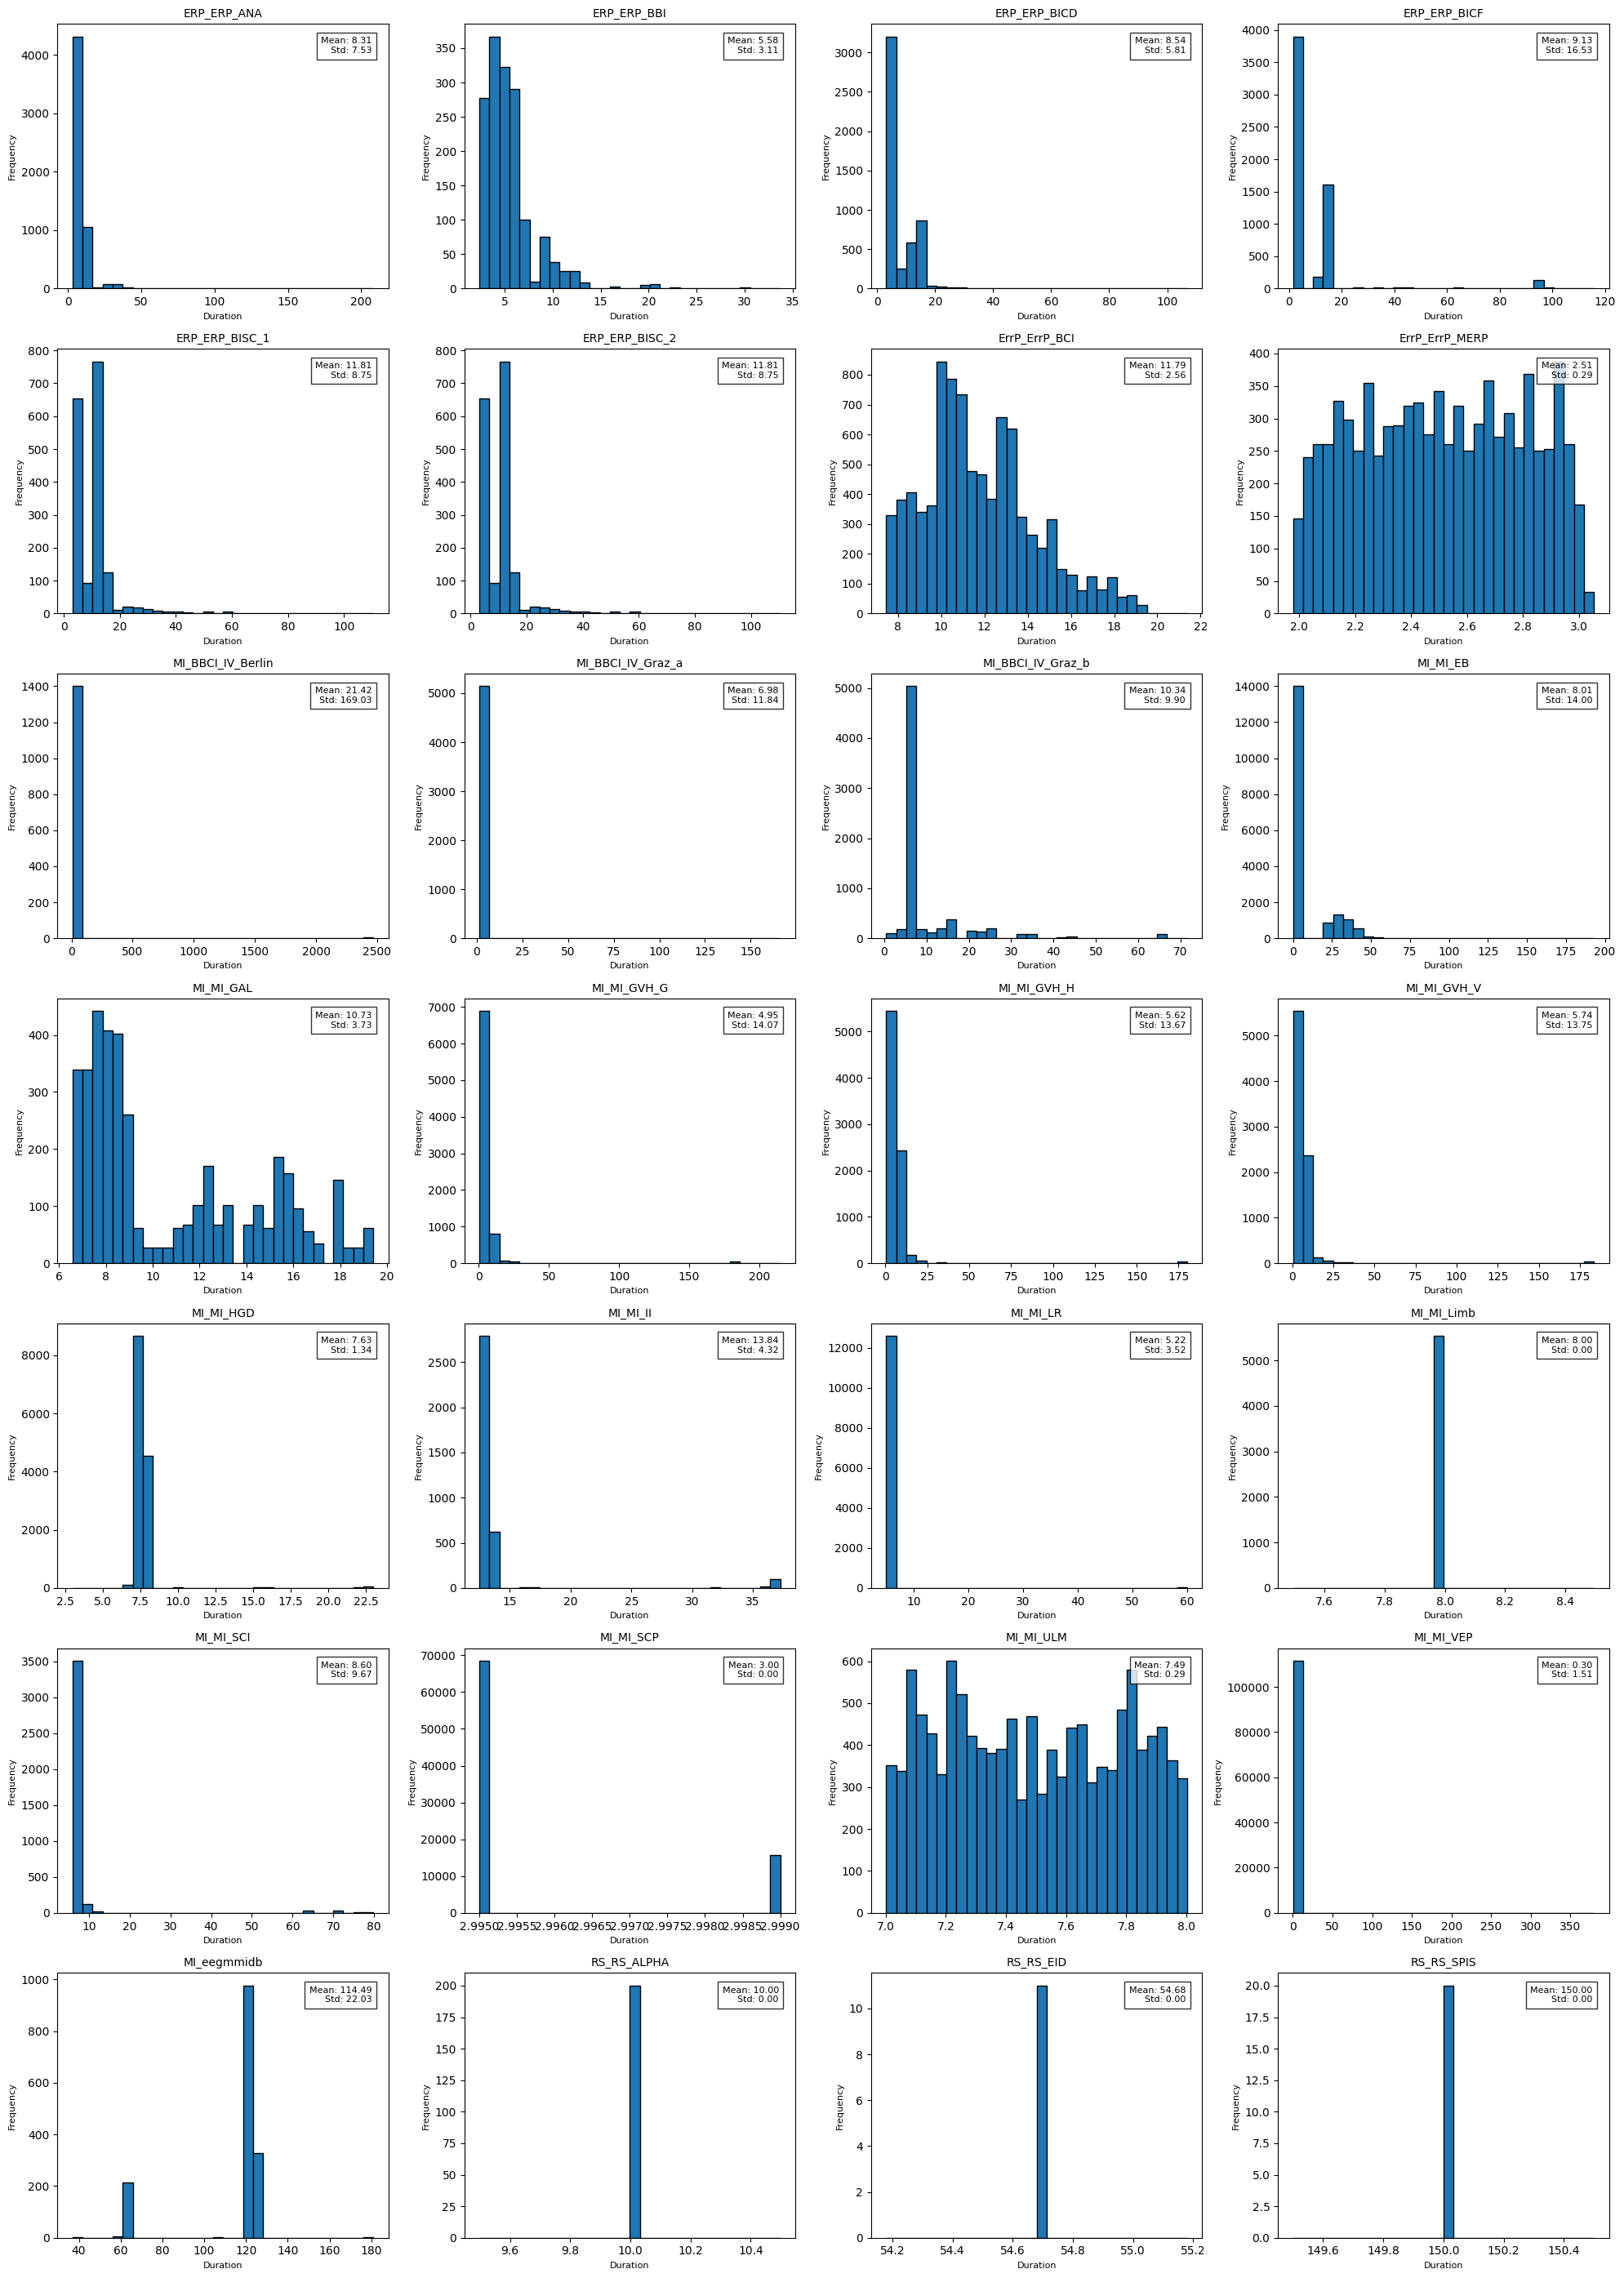

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with a 7x4 grid of subplots
fig, axes = plt.subplots(7, 4, figsize=(20, 28))
axes = axes.flatten()  # Flatten the 7x4 array of axes to iterate easily

# Iterate over the datasets and create a histogram for each
for idx, dataset in enumerate(sorted(dataset_to_durs)):
    durations = dataset_to_durs[dataset]
    mean, std = dataset_to_statistics[dataset]
    
    ax = axes[idx]
    ax.hist(durations, bins=30, edgecolor='black')
    ax.set_title(dataset, fontsize=10)
    ax.set_xlabel('Duration', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.text(0.95, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}', 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

# Hide any remaining empty subplots
for ax in axes[len(dataset_to_durs):]:
    ax.axis('off')

# Adjust layout and spacing
plt.tight_layout()

# Save the figure to a file
fig.savefig('dataset_histograms.png', dpi=300)

# Show the plot (optional)
plt.show()

## Finally: Good collate_fn =========

{'fp1': 16, 'fp2': 16, 'fpz': 16, 'f7': 48, 'f3': 32, 'fz': 32, 'f4': 32} -> 48
torch.Size([7, 1, 240, 48])


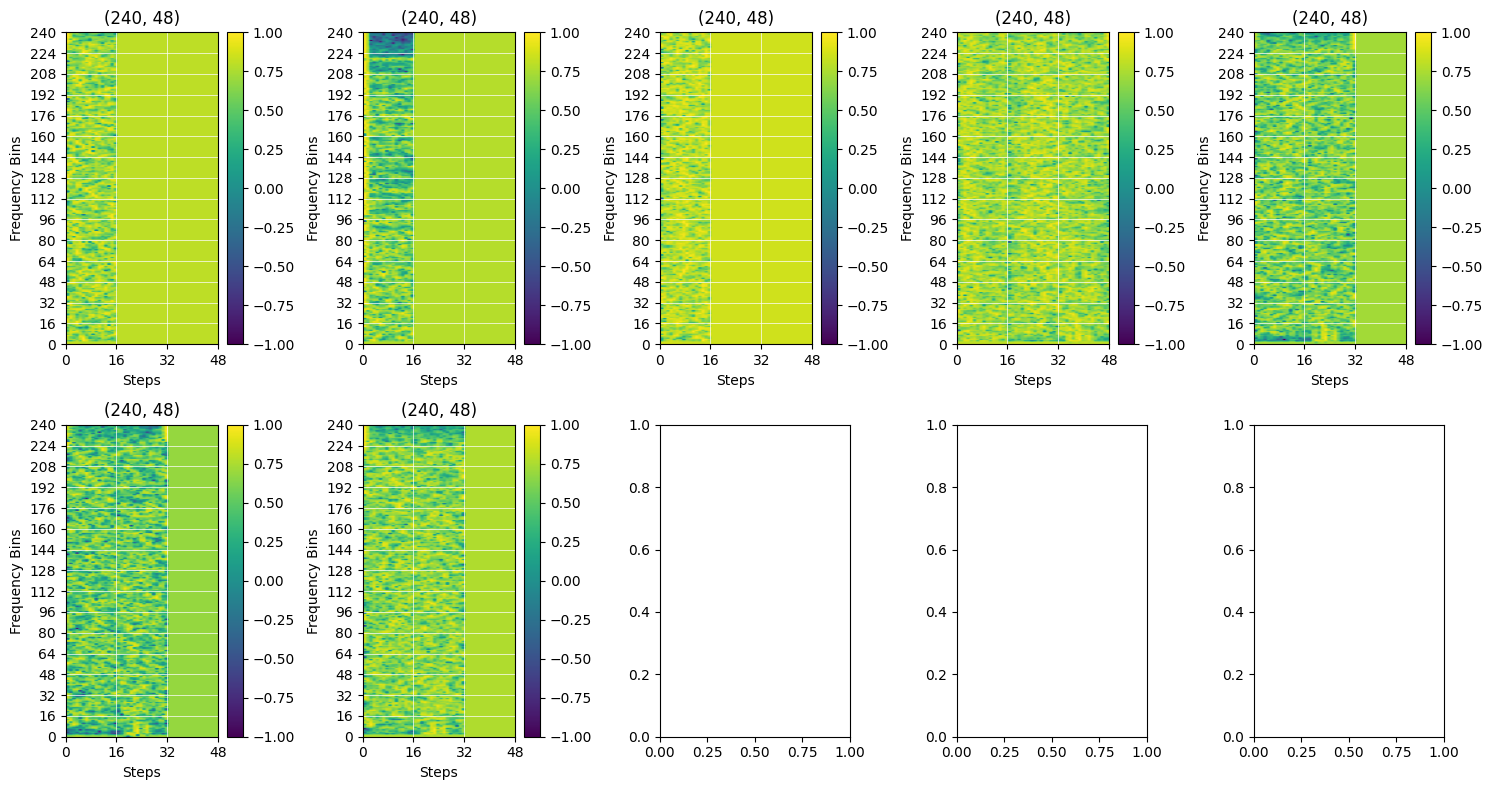

In [37]:
import json
import numpy as np
import torch

import sys
sys.path.append('/home/maxihuber/eeg-foundation')

from src.data.transforms import (
    crop_spg,
    custom_fft,
    crop_and_normalize_spg,
    normalize_spg,
)


# == __getitem__ ==

sr = 500
win_size = 1

trial1_channels = ['FP1', 'FP2', 'FPZ', 'F7']
trial1_paths = ['/scratch/mae/3_30/signal_3_609542.npy', '/scratch/mae/3_30/signal_3_609543.npy', '/scratch/mae/3_30/signal_3_609544.npy', '/scratch/mae/3_30/signal_3_609545.npy']

signals1 = []
channels1 = []
for chn, path in zip(trial1_channels, trial1_paths):
    signal = np.load(path)
    signal = torch.tensor(signal)
    # TODO: crop signal to win_size/4
    signals1.append(signal)
    channels1.append(chn)

trial2_channels = ['F7', 'F3', 'FZ', 'F4']
trial2_paths = ['/scratch/mae/2_79/signal_2_1595784.npy', '/scratch/mae/2_79/signal_2_1595785.npy', '/scratch/mae/2_79/signal_2_1595786.npy', '/scratch/mae/2_79/signal_2_1595787.npy']

signals2 = []
channels2 = []
for chn, path in zip(trial2_channels, trial2_paths):
    signal = np.load(path)
    signal = torch.tensor(signal)
    # TODO: crop signal to win_size/4
    signals2.append(signal)
    channels2.append(chn)

batch = [(signals1, channels1, win_size, sr, 7.448), (signals2, channels2, win_size, sr, 7.768)]


# == collate_fn ==

spgs = {}
total_dur = 0

# Transform signals to spectrograms
for signals, chn_list, _, _, dur in batch:
    # Fourier transform => spectrograms
    fft = custom_fft(
        window_seconds=win_size,
        window_shift=win_size / 4,
        sr=sr,
        cuda=False,
    )

    for chn, signal in zip(chn_list, signals):
        chn = chn.lower()
        spg = fft(signal)
        spg = crop_spg(spg)
        spg = normalize_spg(spg)
        if chn not in spgs:
            spgs[chn] = [spg]
        else:
            spgs[chn].append(spg)

    total_dur += dur

channel_to_len = {chn: sum([spg.shape[1] for spg in spgs[chn]]) for chn in spgs}
max_len = max(channel_to_len.values())
print(channel_to_len, "->", max_len)

# concatenate along time axis, padding up to max_len
spgs_cat_pad_by_channel = []
channels = []
for chn, spectros in spgs.items():
    
    # Concatenate signals from the same channel along the time dimension
    concat_spectros = torch.cat(spectros, dim=1)

    # Determine the amount of padding needed
    padding_length = max_len - concat_spectros.shape[1]
    if padding_length > 0:
        # Apply zero-padding
        padding = torch.zeros((concat_spectros.shape[0], padding_length))
        padded_spectros = torch.cat((concat_spectros, padding), dim=1)
    else:
        # No padding needed if concat_spectros is already of length max_len or more
        padded_spectros = concat_spectros
    
    # spgs_cat_by_channel.append(torch.cat(spectros, dim=1))
    spgs_cat_pad_by_channel.append(padded_spectros)
    channels.append(chn)

batch = torch.stack(spgs_cat_pad_by_channel)
batch.unsqueeze_(1)

print(batch.shape)
plot_batch_spgs(batch)

In [43]:
import glob, os
from natsort import natsorted

paths_to_data_index = natsorted(glob.glob(os.path.join("/scratch/mae", "data_index_*.txt")))
print("[setup] Collecting data from these files:", paths_to_data_index)

[setup] Collecting data from these files: ['/scratch/mae/data_index_0.txt', '/scratch/mae/data_index_1.txt', '/scratch/mae/data_index_2.txt', '/scratch/mae/data_index_3.txt', '/scratch/mae/data_index_4.txt']


## Finding all channel names

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('/home/maxihuber/eeg-foundation')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
import lightning as L

L.seed_everything(0, workers=True)

[rank: 0] Seed set to 0


0

In [3]:
pkl_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json'
with open(pkl_index_path, 'r') as file:
    pkl_index = json.load(file)

pkl_channels = set()
for index_element in pkl_index:
    for chn in index_element["good_channels"]:
        chn_ = chn.lower()
        pkl_channels.add(chn_)

print(pkl_channels)

{'ppo1', 'cz_2', 'ccp7', 'po10_2', 'afz_2', 'pz', 'pz_1', 'fp2_2', 'tp8', 'f7', 'ffc3h', 'ccp2h', 'cpz', 'f4_1', 'ccp1h', 'tpp7h', 'i1', 'o1_1', 'po9_2', 'p4', 'fp1_2', 'tp7', 'ccp5h', 'ppo2h', 't8', 'cp6_1', 'c4_1', 'p8', 'fc5_2', 'ccp4h', 'p7_2', 'o1', 'oi2h', 'fcc3h', 'ftt9h', 'fpz', 'po3', 'po8_1', 'cpp5h', 'f9', 'fp2', 'po9_1', 'po7_1', 'cp2_2', 'f8_1', 'poz', 'ffc4h', 'fcz', 'ffc2h', 'ft10', 'cfc4', 'fft8h', 'ccp1', 'tpp10h', 'f5', 'oz', 'tpp8h', 'po7', 'fc2_1', 'af8', 'fc6', 'ft8', 'cp4', 'p1', 'fcc5h', 't3', 'p7_1', 'f4_2', 't9', 'aff1', 'po1', 'fcc6h', 'fc2_2', 'poo10h', 'fcc1h', 'p08', 'pz_2', 'fc1', 'ccp8', 'cpp3h', 'ttp8h', 'fc6_1', 'cfc5', 'f8_2', 'ccp4', 'c6', 'f7_1', 'c3_2', 'ppo5h', 'm2', 'oz_1', 't7', 'p4_2', 'c3_1', 'tp10', 'oi1h', 'po7_2', 'p3_1', 'cp3', 'o1_2', 'c3', 'p10', 'i2', 't4', 't8_2', 'f3', 'cz_1', 'cpp2h', 'ppo10h', 'fcc2h', 'c2', 'o2_2', 'f3_2', 'po9', 'p5', 'ppo6h', 'poo9h', 'cfc7', 'ppo1h', 'fc5', 'cpp1h', 'f1', 'p8_1', 'c4', 'p7', 'c5', 'po8_2', 'p3_2'

In [7]:
tueg_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'
with open(tueg_index_path, 'r') as file:
    tueg_index = json.load(file)

tueg_channels = set()
for index_element in tueg_index:
    for chn in index_element["channels"]:
        chn_ = chn.lower()
        tueg_channels.add(chn_)

print(tueg_channels)
print([chn for chn in tueg_channels if not chn.endswith("ref")])

{'eeg 30-le', 'eeg 48-ref', 'eeg 49-ref', 'eeg f7-le', 'eeg 20-ref', 'eeg a1-le', 'eeg 44-ref', 'eeg 1x10_lat_01-', 'eeg luc-ref', 'eeg ekg-le', 'eeg 93-ref', 'eeg fp1-le', 'eeg sp1-ref', 'eeg 115-ref', 'eeg ekg-ref', 'eeg cz-c3', 'eeg c4-cz', 'eeg f8-t4', 'eeg fp2-le', 'eeg 67-ref', 'eeg sp2-ref', 'eeg 118-ref', 'eeg 116-ref', 'eeg 55-ref', 'eeg 81-ref', 'eeg pz-ref', 'eeg 26-ref', 'eeg p3-ref', 'eeg 98-ref', 'eeg a1-ref', 'eeg 29-le', 'eeg 77-ref', 'eeg 101-ref', 'eeg 31-le', 'eeg 35-ref', 'eeg p4-ref', 'eeg 60-ref', 'eeg 65-ref', 'eeg f7-ref', 'eeg t3-t5', 'eeg 91-ref', 'eeg 74-ref', 'eeg 22-le', 'eeg 30-ref', 'eeg 127-ref', 'eeg 53-ref', 'eeg t1-t2', 'eeg 37-ref', 'eeg 1x10_lat_04-', 'eeg 113-ref', 'eeg 69-ref', 'eeg 90-ref', 'eeg 117-ref', 'eeg 58-ref', 'eeg f8-ref', 'eeg p3-le', 'eeg fp2-ref', 'eeg 36-ref', 'eeg c3p-ref', 'eeg a2-ref', 'eeg t2-ref', 'eeg 80-ref', 'eeg 28-ref', 'eeg t1-ref', 'eeg 95-ref', 'eeg 105-ref', 'eeg 87-ref', 'eeg 85-ref', 'eeg t1-le', 'eeg pg2-ref', 'eeg 

In [15]:
all_channels = natsorted(list(set.union(pkl_channels,tueg_channels)))
print(all_channels)

['a1', 'a2', 'af3', 'af4', 'af7', 'af8', 'aff1', 'aff2', 'aff5h', 'aff6h', 'afp3h', 'afp4h', 'afz', 'afz_1', 'afz_2', 'c1', 'c2', 'c3', 'c3_1', 'c3_2', 'c4', 'c4_1', 'c4_2', 'c5', 'c6', 'ccp1', 'ccp1h', 'ccp2', 'ccp2h', 'ccp3', 'ccp3h', 'ccp4', 'ccp4h', 'ccp5', 'ccp5h', 'ccp6', 'ccp6h', 'ccp7', 'ccp8', 'cfc1', 'cfc2', 'cfc3', 'cfc4', 'cfc5', 'cfc6', 'cfc7', 'cfc8', 'cp1', 'cp1_1', 'cp1_2', 'cp2', 'cp2_1', 'cp2_2', 'cp3', 'cp4', 'cp5', 'cp5_1', 'cp5_2', 'cp6', 'cp6_1', 'cp6_2', 'cpp1h', 'cpp2h', 'cpp3h', 'cpp4h', 'cpp5h', 'cpp6h', 'cpz', 'cz', 'cz_1', 'cz_2', 'eeg 1x10_lat_01-', 'eeg 1x10_lat_02-', 'eeg 1x10_lat_03-', 'eeg 1x10_lat_04-', 'eeg 1x10_lat_05-', 'eeg 20-le', 'eeg 20-ref', 'eeg 21-le', 'eeg 21-ref', 'eeg 22-le', 'eeg 22-ref', 'eeg 23-le', 'eeg 23-ref', 'eeg 24-le', 'eeg 24-ref', 'eeg 25-le', 'eeg 25-ref', 'eeg 26-le', 'eeg 26-ref', 'eeg 27-le', 'eeg 27-ref', 'eeg 28-le', 'eeg 28-ref', 'eeg 29-le', 'eeg 29-ref', 'eeg 30-le', 'eeg 30-ref', 'eeg 31-le', 'eeg 31-ref', 'eeg 32-le'

In [22]:
def map_channel_name(channel_name):
    # Remove "eeg " prefix if present
    if channel_name.startswith("eeg "):
        channel_name = channel_name[4:]
    # Simplify names with a dash and check if it ends with "-"
    if '-' in channel_name:
        if channel_name.endswith('-'):
            return "None"
        return channel_name.split('-')[0]
    return channel_name

from natsort import natsorted
all_generic_channels = natsorted(list(set([map_channel_name(chn) for chn in all_channels])) + ['avg_ref'])
print(all_generic_channels)

['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', 'None', 'a1', 'a2', 'af3', 'af4', 'af7', 'af8', 'aff1', 'aff2', 'aff5h', 'aff6h', 'afp3h', 'afp4h', 'afz', 'afz_1', 'afz_2', 'avg_ref', 'c1', 'c2', 'c3', 'c3_1', 'c3_2', 'c3p', 'c4', 'c4_1', 'c4_2', 'c4p', 'c5', 'c6', 'ccp1', 'ccp1h', 'ccp2', 'ccp2h', 'ccp3', 'ccp3h', 'ccp4', 'ccp4h', 'ccp5', 'ccp5h', 'ccp6', 'ccp6

In [23]:
from socket import gethostname
all_channels_path = '/scratch/mae/all_channels.txt'
with open(all_channels_path, 'w') as file:
    json.dump(all_generic_channels, file)
    print(f"Dumped channels to {gethostname()}")

Dumped channels to tikgpu10


In [26]:
tueg_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'
with open(tueg_index_path, 'r') as file:
    tueg_index = json.load(file)

single_channel_duration = 0
multi_channel_duration = 0
for index_element in tueg_index:
    single_channel_duration += len(index_element["channels"]) * index_element["duration"]
    multi_channel_duration += index_element["duration"]

print(single_channel_duration)
print(multi_channel_duration)

2817389417.852209
97433965.35720438


In [39]:
patch_size = 16
factor = .25

def get_nr_patches(n_channels, win_size, win_shift, sr, dur):
    nr_y_patches = int(sr // 2 * win_size // patch_size)
    x_datapoints_per_second = 1 / win_shift
    x_datapoints = dur * x_datapoints_per_second
    nr_x_patches = int(x_datapoints // patch_size)
    return n_channels * nr_y_patches * nr_x_patches

win_size = 4
get_nr_patches(1, win_size, win_size*factor, 256, 15)

pkl_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'
with open(pkl_index_path, 'r') as file:
    pkl_index = json.load(file)

max_duration = max([index_element["duration"] for index_element in pkl_index])
print(max_duration)

shit_samples = []
for index_element in pkl_index:
    if 1 <= index_element["duration"] and index_element["duration"] < 2 and index_element["sr"] < 128:
        shit_samples.append(index_element)

print(len(shit_samples))

0


In [40]:
max_duration = max([index_element["duration"] for index_element in pkl_index])
print(max_duration)

88424.9975


In [41]:
pkl_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_pkl_index.json'
subjects = set()
with open(pkl_index_path, 'r') as file:
    pkl_index = json.load(file)
    for index_element in pkl_index:
        subjects.add(index_element["SubjectID"])
print(len(subjects))

593


In [44]:
dataset_to_hw_path = '/home/maxihuber/eeg-foundation/development/experiment_management/dataset_to_hw.json'
hw_to_montage_path = '/home/maxihuber/eeg-foundation/development/experiment_management/montage.json'

with open(dataset_to_hw_path, 'r') as file:
    dataset_to_hw_map = json.load(file)

with open(hw_to_montage_path, 'r') as file:
    hw_to_montage_path = json.load(file)

dataset_to_montage = {}

for dataset, hw in dataset_to_hw_map.items():
    montage = hw_to_montage_path[hw]
    dataset_to_montage[dataset] = montage

dataset_to_montage_path = '/home/maxihuber/eeg-foundation/development/experiment_management/dataset_to_montage.json'
with open(dataset_to_montage_path, 'w') as file:
    json.dump(dataset_to_montage, file, indent=4)
    print("Dumped file!")

Dumped file!


In [66]:
sr=500
dur=7.978

patch_size=16
win_size=1
win_shift_factor=.25

def get_nr_y_patches(win_size, sr):
    return int((sr // 2 * win_size + 1) // patch_size)

def get_nr_x_patches(win_size, dur):
    win_shift = win_size * win_shift_factor
    x_datapoints_per_second = 1 / win_shift
    x_datapoints = dur * x_datapoints_per_second + 1
    return int(x_datapoints // patch_size)

y_patches, x_patches = get_nr_y_patches(win_size, sr), get_nr_x_patches(win_size, dur)
print(f"{y_patches}x{x_patches}", "=>", y_patches * x_patches)

from src.data.transforms import custom_fft, crop_spg, normalize_spg

fft = custom_fft(
    window_seconds=win_size,
    window_shift=win_size * win_shift_factor,
    sr=sr,
    cuda=False,
)

def normalize_spg(spg):
    # Divide spectrogram by frequency bin-wise means
    freq_means = spg[:, :].mean(dim=1, keepdim=True)
    # Divide each frequency bin by its mean
    normalized_spg = spg[:, :] / freq_means
    # Transform to decibel-scale
    db_spg = 10 * torch.log10(normalized_spg)
    db_mean = 10 * torch.log10(freq_means)
    return db_spg, db_mean

signal = torch.randn(int(sr*dur))
spg = fft(signal)
print(spg.shape)
spg = crop_spg(spg)
spg, mean = normalize_spg(spg)
print(mean.shape)
print(f"{spg.shape[0]//patch_size}x{spg.shape[1]//patch_size}", "=>", spg.shape[0] * spg.shape[1] // (patch_size**2))

15x2 => 30
torch.Size([251, 32])
torch.Size([240, 1])
torch.Size([240, 1])
15x2 => 30


In [52]:
max_nr_patches = 8_500
patch_size=16
win_size=.25
win_shift_factor = 4

for sr in [120, 128, 250, 256, 512, 717, 1000]:
    max_dur = int( ((patch_size ** 2) * max_nr_patches - sr * win_size / 2 - 1) / (sr / win_shift_factor / 2 + 1 / win_shift_factor / win_size) )
    print(max_dur)
    y_patches, x_patches = get_nr_y_patches(win_size, sr), get_nr_x_patches(win_size, max_dur)
    print(f"{y_patches}x{x_patches}", "=>", y_patches * x_patches)

135999
1x8500 => 8500
127999
1x8000 => 8000
67471
2x4217 => 8434
65938
2x4121 => 8242
33475
4x2092 => 8368
24010
5x1500 => 7500
17268
7x1079 => 7553


In [64]:
class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, patch_size=16, in_chans=1, embed_dim=384):
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = x.float()
        print(x.shape)
        x = self.proj(x)
        print(x.shape)
        x = x.flatten(2)
        print(x.shape)
        x = x.transpose(1, 2)
        print(x.shape)
        return x

#patch_embed = PatchEmbed(patch_size=16, in_chans=1, embed_dim=384)

batch = [[0,1,2,3],[4,5,6,7],[8,9,10,11]]
batch = torch.tensor(batch)
batch.unsqueeze_(0).unsqueeze_(0)
print(batch.shape)
print(batch)
batch = batch.flatten(2)
print(batch.shape)
print(batch)
batch = batch.reshape(1,1,3,4)
print(batch.shape)
print(batch)

torch.Size([1, 1, 3, 4])
tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]]]])
torch.Size([1, 1, 12])
tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]])
torch.Size([1, 1, 3, 4])
tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]]]])


In [8]:
from natsort import natsorted
import glob

path1 = '/scratch/mae/4_2/signal_4_44098.npy'
path2 = '/scratch/mae/4_59/signal_4_1196749.npy'

stor_dir="/scratch/mae"
data_index_pattern="data_index_*"

paths_to_data_index = natsorted(
    glob.glob(os.path.join(stor_dir, data_index_pattern))
)
print("[setup] Collecting data from these files:", paths_to_data_index)

# full_trial_index = {}
full_channel_index = {}
num_trials = 0
num_signals = 0
data_seconds = 0

for path_to_data_index in paths_to_data_index:
    with open(path_to_data_index, "r") as index_file:
        # Read information about a subset of the files
        trial_index = json.load(index_file)
        for _, trial_info in trial_index.items():
            # full_trial_index[num_trials] = trial_info
            for chn, path in zip(trial_info["channels"], trial_info["paths"]):
                if path == path1 or path == path2:
                    print(f"{path}: {trial_info['Dataset']}")
                full_channel_index[num_signals] = {
                    "path": path,
                    "channel": chn,
                    "sr": trial_info["sr"],
                    "dur": trial_info["dur"],
                    "trial_idx": num_trials,
                    "SubjectID": trial_info["SubjectID"],
                }
                num_signals += 1
                data_seconds += trial_info["dur"]
            num_trials += 1


[setup] Collecting data from these files: ['/scratch/mae/data_index_0.txt', '/scratch/mae/data_index_1.txt', '/scratch/mae/data_index_2.txt', '/scratch/mae/data_index_3.txt', '/scratch/mae/data_index_4.txt']
/scratch/mae/4_2/signal_4_44098.npy: MI_MI_SCP
/scratch/mae/4_59/signal_4_1196749.npy: MI_MI_SCP


In [ ]:
pkl_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'

id_to_srs = {}
id_to_dataset = {}

with open(pkl_index_path, 'r') as file:
    pkl_index = json.load(file)

for el in pkl_index:
    if not el["SubjectID"] in id_to_srs:
        id_to_srs[el["SubjectID"]] = set()
        id_to_dataset[el["SubjectID"]] = set()
    id_to_srs[el["SubjectID"]].add(el["sr"])
    #id_to_dataset[el["SubjectID"]].add(el["Dataset"])

for id in id_to_srs:
    if len(id_to_srs[id]) > 1:
        print(f"{id}: {id_to_dataset[id]}, {id_to_srs[id]}")

In [18]:
import torch

# Example input tensor and parameters
sr = 250  # Sample rate (e.g., 44100 samples per second)
max_dur = 1  # Maximum duration in seconds
channel_signal = torch.arange(0, int(sr * 5.564), dtype=torch.float32)  # Example signal for 5 seconds

# Calculate the number of samples per chunk based on max_dur
jump = int(sr * max_dur)

# Split the signal into chunks
chunks = channel_signal.unfold(0, jump, jump)

# Printing the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

# If you want the chunks as a list of tensors
chunks_list = [chunk for chunk in chunks]

Chunk 1: tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147.,

In [60]:
tueg_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/full_tueg_index.json'

with open(tueg_index_path, 'r') as file:
    tueg_index = json.load(file)

tueg_shortened_index = []
for i, el in enumerate(tueg_index):
    if i % 3 == 0:
        tueg_shortened_index.append(el)

print(len(tueg_index))
print(len(tueg_shortened_index))

assert False

athirdof_tueg_index_path = '/itet-stor/maxihuber/deepeye_storage/index_files/athirdof_tueg_index.json'
with open(athirdof_tueg_index_path, 'w') as file:
    json.dump(tueg_shortened_index, file)
    print("Dumped file!")

69652
23218
Dumped file!


In [68]:
[["FP1"] * 5] * 3

[['FP1', 'FP1', 'FP1', 'FP1', 'FP1'],
 ['FP1', 'FP1', 'FP1', 'FP1', 'FP1'],
 ['FP1', 'FP1', 'FP1', 'FP1', 'FP1']]

In [75]:
H, W = 3, 4
snake_spg = torch.tensor([[0,1,2,3],[4,5,6,7],[8,9,10,11]])
print(snake_spg)
batch_size = 2
snake_batch = snake_spg.view(batch_size, -1, W // batch_size)
print(snake_batch)

[[]] * batch_size

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])


[[], []]

## Test snake_collate_fn

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('/home/maxihuber/eeg-foundation')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio
import lightning as L

L.seed_everything(0, workers=True)

[rank: 0] Seed set to 0


0

In [4]:
import re

def parse_line(line):
    # Extract details from the line using regex
    pattern = r'\[snake_collate_fn\] Sample \d+: channel=(.*?), sr=(\d+), dur=(.*?), path=(.*)'
    match = re.match(pattern, line)
    if match:
        channel = match.group(1)
        sr = int(match.group(2))
        dur = float(match.group(3))
        path = match.group(4)
        # Generate a dummy signal tensor for demonstration purposes
        signal = torch.tensor([0.0])  # Replace with actual signal loading logic if needed
        return {
            "signal": signal,
            "path": path,
            "channel": channel,
            "sr": sr,
            "dur": dur,
        }
    return None

def load_batch_file(file_path):
    batch_list = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parsed_dict = parse_line(line)
                if parsed_dict:
                    batch_list.append(parsed_dict)
    return batch_list

def __getitem__(channel_info):
    signal = np.load(channel_info["path"])
    return {
        "signal": torch.tensor(signal),
        "path": channel_info["path"],
        "channel": channel_info["channel"],
        "sr": channel_info["sr"],
        "dur": channel_info["dur"],
    }

# Load the batch file and convert it to a list of dictionaries
batch_file_path = '/home/maxihuber/eeg-foundation/src/data/components/batch.txt'
batch_info = load_batch_file(batch_file_path)

batch = [__getitem__(channel_info) for channel_info in batch_info]
print(len(batch))

189


In [5]:
# Class attributes (LightningDataModule)
self_win_shifts = [.25, .5, 1, 2, 4, 8]
self_win_shift_factor = .25
self_patch_size = 16
self_max_nr_patches = 8_500
self_max_nr_y_patches = int(500 * self_win_shifts[-1] // self_patch_size)
self_max_y_datapoints = self_max_nr_y_patches * self_patch_size
#self_max_nr_x_patches = int(1 / (self_win_shifts[0] * self_win_shift_factor) * 3_600 // self_patch_size) # not used
self_none_channel_probability = 0.2

self_channel_name_map_path = "/home/maxihuber/eeg-foundation/src/data/components/channels_to_id.json"
with open(self_channel_name_map_path, 'r') as file:
    self_channel_name_map = json.load(file)

# Helper methods
def self_train_sampler_get_nr_y_patches(win_size, sr):
    return int((sr / 2 * win_size + 1) / self_patch_size)

def self_train_sampler_get_nr_x_patches(win_size, dur):
    win_shift = win_size * self_win_shift_factor
    x_datapoints_per_second = 1 / win_shift
    x_datapoints = dur * x_datapoints_per_second + 1
    return int(x_datapoints / self_patch_size)

def self_get_generic_channel_name(channel_name):
    channel_name = channel_name.lower()
    # Remove "eeg " prefix if present
    if channel_name.startswith("eeg "):
        channel_name = channel_name[4:]
    # Simplify names with a dash and check if it ends with "-"
    if "-" in channel_name:
        if channel_name.endswith("-"):
            return "None"
        return channel_name.split("-")[0]
    return channel_name

def self_encode_mean(mean):
    y_datapoints = mean.shape[0]
    encoded_mean = torch.zeros(self_max_y_datapoints)
    step_size = int(self_win_shifts[-1] // win_size)
    end_idx = step_size * y_datapoints
    indices = torch.arange(0, end_idx, step_size)
    #print(step_size, end_idx, "=>", len(indices))
    encoded_mean[indices] = mean.squeeze_().float()
    encoded_mean.unsqueeze_(1)
    return encoded_mean

In [48]:
import random
from src.data.transforms import custom_fft, crop_spg, normalize_spg

### Snake collate function ###

batch_len = len(batch)
print("[snake_collate_fn] # signals:", batch_len, file=sys.stderr)

srs = [sample["sr"] for sample in batch]
assert all(
    sr == srs[0] for sr in srs
), f"[snake_collate_fn] Differing sampling rates within batch, srs={srs}"

sr = srs[0]
min_dur = min([sample["dur"] for sample in batch])

# Randomly sample a win_size for the STFT
valid_win_shifts = [
    win_shift
    for win_shift in self_win_shifts
    if self_train_sampler_get_nr_y_patches(win_shift, sr) >= 1
    and self_train_sampler_get_nr_x_patches(win_shift, min_dur) >= 1
]
assert (
    len(valid_win_shifts) > 0
), "[snake_collate_fn] No valid valid_win_shifts found"

# print("[snake_collate_fn] Sampling set:", valid_win_shifts, file=sys.stderr)
win_size = random.choice(valid_win_shifts)

fft = custom_fft(
    window_seconds=win_size,
    window_shift=win_size * self_win_shift_factor,
    sr=sr,
    cuda=False,
)

spgs = []  # Spectrograms of this batch
chns = []  # List to store channel tensors for each patch
spgs_w = set()  # Widths of the spectrograms

H, W = 0, 0

for i, sample in enumerate(batch):

    signal = sample["signal"]

    channel_name = self_get_generic_channel_name(sample["channel"])
    if channel_name in self_channel_name_map:
        p = random.random()  # Sample p from a uniform distribution over [0, 1)
        channel = self_channel_name_map[channel_name] if p > self_none_channel_probability else self_channel_name_map["None"]
    else:
        channel = self_channel_name_map["None"]

    # STFT
    spg = fft(signal)
    spg = crop_spg(spg)

    H_new, W_new = spg.shape[0], spg.shape[1]
    h_new, w_new = H_new // self_patch_size, W_new // self_patch_size

    # Create a tensor filled with the current channel value
    channel_tensor = torch.full((h_new, w_new), channel, dtype=torch.float32)

    spgs.append(spg)
    chns.append(channel_tensor)
    spgs_w.add(w_new)

    H = H_new
    W += W_new

total_patches = H * W // (self_patch_size**2)

assert (
    total_patches <= self_max_nr_patches
), f"Total patches: {total_patches}, Max patches: {self_max_nr_patches}"

h, w = H // self_patch_size, W // self_patch_size
print(f"[snake_collate_fn] total_patches: {h*w}, (h,w)=({h},{w}), (H,W)=({H},{W})", file=sys.stderr)

# Now, given the H, W information, we can create a tensor of desired shape (B, H_new, W_new)

# First, randomly sample a valid batch size
batch_size = random.choice(
    [
        batch_size
        for batch_size in range(1, batch_len + 1)
        if w % batch_size == 0
    ]
)

print(f"[snake_collate_fn] batch_size: {batch_size}", file=sys.stderr)

spgs_rows = []
chns_rows = []
means_rows = []

row_size = W // batch_size
print(f"[snake_collate_fn] row_size: {row_size}", file=sys.stderr)

cur_row = 0
cur_spgs = []
cur_chns = []
cur_means = []
cur_W = 0

for spg, chn in zip(spgs, chns):
    if cur_W + spg.shape[1] <= row_size:
        # Can use full spg
        spg, mean = normalize_spg(spg)
        mean = self_encode_mean(mean)
        cur_spgs.append(spg)
        cur_chns.append(chn)
        cur_means.append(mean)
        cur_W += spg.shape[1]
        if cur_W == row_size:
            cur_W = 0
            spgs_rows.append(cur_spgs)
            chns_rows.append(cur_chns)
            means_rows.append(cur_means)
            cur_spgs = []
            cur_chns = []
            cur_means = []
    else:
        # Need to split this spg to multiple rows
        #  in a while loop
        spg_W = spg.shape[1]
        spg_W_taken = 0
        while spg_W > 0:
            take_W = min(spg_W, row_size - cur_W)
            spg_chunk = spg[:, spg_W_taken:spg_W_taken+take_W]
            chn_chunk = chn[:, (spg_W_taken//self_patch_size):((spg_W_taken+take_W) // self_patch_size)]
            spg_chunk, mean_chunk = normalize_spg(spg_chunk)
            mean_chunk = self_encode_mean(mean_chunk)
            cur_spgs.append(spg_chunk)
            cur_chns.append(chn_chunk)
            cur_means.append(mean_chunk)
            spg_W -= take_W
            cur_W += take_W
            spg_W_taken += take_W
            cur_W %= row_size
            if cur_W == 0:
                spgs_rows.append(cur_spgs)
                chns_rows.append(cur_chns)
                means_rows.append(cur_means)
                cur_spgs = []
                cur_chns = []
                cur_means = []

# Concatenate rows
final_batch = torch.stack([torch.cat(row, dim=-1) for row in spgs_rows])
channels = torch.stack([torch.cat(row, dim=-1) for row in chns_rows])

max_nr_mean_patches = max([len(means) for means in means_rows])
means_rows = [torch.cat(means, dim=-1) for means in means_rows]
means_rows = [
    F.pad(means, (0, max_nr_mean_patches - means.shape[1]), mode='constant', value=0)
    for means in means_rows
]
means = torch.stack(means_rows)

assert (
    final_batch.shape[1] == channels.shape[1]*self_patch_size
), f"Batch shape: {final_batch.shape[1]}, Channels shape: {channels.shape[1]*self_patch_size}"
assert (
    final_batch.shape[2] == channels.shape[2]*self_patch_size
), f"Batch shape: {final_batch.shape[2]}, Channels shape: {channels.shape[2]*self_patch_size}"

final_batch.unsqueeze_(1)

# Flatten the channels tensor, the batch will be automatically by the network
channels = channels.flatten(1)
means = means.transpose(1, 2)

B, C, H, W = final_batch.shape

# Send the constructed batch to the network
print(f"[return] final_batch.shape: {final_batch.shape}", file=sys.stderr)
print(f"[return] channels.shape: {channels.shape}", file=sys.stderr)
print(f"[return] means.shape: {means.shape}", file=sys.stderr)
print(f"[return] win_size: {win_size}", file=sys.stderr)

[snake_collate_fn] # signals: 189
[snake_collate_fn] total_patches: 4515, (h,w)=(15,301), (H,W)=(240,4816)
[snake_collate_fn] batch_size: 43
[snake_collate_fn] row_size: 112
[return] final_batch.shape: torch.Size([43, 1, 240, 112])
[return] channels.shape: torch.Size([43, 105])
[return] means.shape: torch.Size([43, 7, 4000])
[return] win_size: 1


### Mean embeddings

In [ ]:
mean_embed = nn.Linear(
    in_features=self_max_y_datapoints,
    out_features=384,
)

# Apply mean embedding
B, M, _ = means.shape
means = means.reshape(B * M, -1)
means = mean_embed(means)
means = means.reshape(B, M, -1)

### Reconstruction loss only on masked patches

In [501]:
def random_masking_smart(batch, mask_ratio=0.5, nr_meta_tokens=0):
    B, N, D = batch.shape

    num_tokens_to_mask = int((N - nr_meta_tokens) * mask_ratio)
    
    rand_indices, _ = torch.rand(B, N - nr_meta_tokens, device=batch.device).argsort(dim=1)[:, :num_tokens_to_mask].sort(dim=1) 
    rand_indices += nr_meta_tokens

    # Boolean mask
    mask = torch.zeros(B, N, dtype=torch.bool, device=batch.device)
    mask.scatter_(1, rand_indices, True)
    
    # Zero out the patches at the chosen indices
    batch.masked_fill_(mask.unsqueeze(-1), 0)
    
    # Extract the masked elements
    # masked_batch = batch[mask].view(B, num_tokens_to_mask, D)
    
    return batch, rand_indices, mask

B, N, D = 2, 16, 256

target = torch.randn(B, N, D)
pred = torch.randn(B, N, D)

masked_target, mask = random_masking_smart(target, mask_ratio=0.5, nr_meta_tokens=0)

print(mask)

loss = (pred - target) ** 2
print(loss.shape)
print()

loss = loss.mean(dim=-1)
print(loss.shape)
print(loss)
print()

loss = loss[mask].view(B, -1)
print(loss.shape)
print(loss)

tensor([[ 3,  5,  9, 10, 11, 12, 13, 15],
        [ 1,  4,  6,  7,  9, 11, 13, 14]])
tensor([[False, False, False,  True, False,  True, False, False, False,  True,
          True,  True,  True,  True, False,  True],
        [False,  True, False, False,  True, False,  True,  True, False,  True,
         False,  True, False,  True,  True, False]])
torch.Size([2, 16, 256])

torch.Size([2, 16])
tensor([[2.1050, 2.1228, 1.9105, 2.0540, 2.0876, 1.9725, 1.8128, 1.8919, 2.0697,
         1.9219, 1.9260, 1.7507, 2.0004, 2.0928, 2.2065, 1.8684],
        [1.9890, 2.1419, 1.7104, 1.8812, 1.8890, 1.9228, 2.0208, 2.0291, 1.9836,
         1.6011, 1.9884, 2.1399, 2.2725, 1.7695, 2.2537, 2.1328]])

torch.Size([2, 8])
tensor([[2.0540, 1.9725, 1.9219, 1.9260, 1.7507, 2.0004, 2.0928, 1.8684],
        [2.1419, 1.8890, 2.0208, 2.0291, 1.6011, 2.1399, 1.7695, 2.2537]])
